# Capstone Project - Guess the Game!  
By Grandadam Patrik 

## Table Of Contents:
1. [Executive Summary](#Summary)  
     a. [Introduction](#Intro)  
     b. [Methodology](#Method)  
     c. [Modelling](#Models)  
     d. [Results](#Results)  
2. [Data Preparation](#Prep)  
    a. [Data collection](#collec)  
    b. [Data cleaning](#clean)  
    c. [Feature encoding](#encoding)
3. [Feature engineering & Exploratory Data Analysis (EDA)](#EDA)  
    a. [Plots of chess positions](#plots)  
    b. [Feature engineering](#eng)  
    c. [Feature exploration](#explo)  
    d. [Further exploration](#further)
4. [Saving the dataframes](#df)  
    a. ["Engineered" dataframe](#engdf)  
    b. ["Full" dataframe](#fulldf)
5. [Futher EDA](#EDA2)  
    a. [PCA on df_eng](#PCA1)  
    b. [PCA on all the features](#PCA2)

# 1. Executive Summary <a class="anchor" id="Summary"></a>

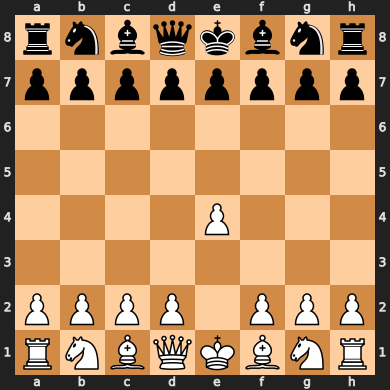

In [1]:
import chess
import chess.variant
board = chess.Board('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 1')
board

## Introduction <a class="anchor" id="Intro"></a>

The picture above illustrates a chessboard after white's first move "e2-e4". However, it is not possible to affirm that the game played is "standard chess".  
Indeed, multiple chess "variants" exist. A variant could be defined as a game that a played on a chess board and which rules are inspired by chess, but that differs from it in some ways. 
Examples of the different variants can be found under https://lichess.org/variant.  

**The goal of this project is to predict the variant that is played on a given chess board.**  

The project will be focus on the 9 variants that can be played on lichess.org. 

## Methdology <a class="anchor" id="Method"></a>

### Data Extraction and processing

We start by extracting the data from lichess.org by using its API and the berserk's client (https://berserk.readthedocs.io/en/master/index.html ).  
The data is then cleaned and processed through the following steps:  
- extracting random games, removing aborted games  
- cleaning the data to extract relevant information and convert it to "user-friendly" lists  
- "playing" the moves on a board to get the position after N moves, extracting relevant data from the games  
- extracting the position on the board to obtain an array of length 64 representing the 64 squares of the board and the piece standing on each square  
- encoding to convert each of the 64 squares into binary variables that will be used later in the different models  

The output of this preprocessing steps is a clean dataframe of 1000 observations from each variant (=9000 observations in total). 
The main information contained in this dataframe is the variant played on a given board and multiple encoded features derived from the position after N moves.   

### Exploratory Data Analysis

From this dataframe, an EDA is performed. Diagrams of different positions from each variant are plotted and provide us more knowledge on the data. They help us to figure out rules that might have an importance in the prediction task.  
From these first insights, we engineer multiple features and assess their relevance by looking at their distributions in the different variants.  
The results shown are the result of an iterative process:  
- reflection on features that could be helpful based on the graphs and domain knwoledge  
- test of the features  
- improving/removing features and including new features  
- adding the selected features to the final dataframe  

Through this process, it was quickly possible to discover features that discriminate the data well, like the total number of pieces (especially pawns and kings) on the board, the number of trades, the number of checks given or the positionning of certains pieces on key squares.  
This analysis helped to distinguish variants that would be easy to predict as multiple features discriminated them well like racingKings, horde or to a lower extent antichess, atomic and chess960.  
On the other side, other variants seemed much more challenging to predict Even if some features have proven to vary between the remaining variants, no clear pattern could be distinguished.  
Based on the output of the EDA, we create 

## Modelling <a class="anchor" id="Models"></a>

Multiple strategies are tested to predict the variant of a given game. After having split the data into training and testing set, we use a grid-search cross-validation to tuned hyperparameters in a training step and predict the variants of unseen data in the testing set. The following models are considered : Decision Tree, Logistic Regression, SVM, Random Forest, Neural Networks. These models are applied to muliple datasets and using different strategies summarized below:  
- Tuning the models on only engineered features, predicting the variant of the testing set and evaluating the accuracy  
- Tuning the models on the whole dataset and predicting the variant of the testing set and evaluating the accuracy  
- Tuning the models using a nested strategy:  
    1. Creating "groups of variants", tuning the models and predicting the group of variant of the testing set (+ iteratively "tuning" the groups of variants, testing different combinations)    
    2. Splitting the testing set into subsets based on the previous prediction  
    3. Predicting the variant for each of the subsets and evaluating the accuracy  
- Using a PCA on the whole dataset, tuning the models, predicting the variant of the testing set and evaluating the accuracy    
- Using a neural network on a bigger sample of 5000 games per variant

While the overall objective is to maximise the likelihood of predicting correctly a given game (i.e. the main criterion is the accuracy), other criterion such as the computation time, the overall F1, precision and recall are also monitored. The notion of trade-off between the accuracy and the computational complexity will play an important role in the analysis and might be a criterion of decision. 

## Results <a class="anchor" id="Results"></a>

We come up with two models that overperform and that should be considered:
- SVM model applied on the whole dataset that has the best accuracy (> 88%) and also performs best for the other criterion but that is quite complex  
- SVM using first a PCA with 89 components that has a very good accuracy as well and which training time is clearly lower



---
# Data Preparation <a class="anchor" id="Prep"></a>

The first objective is to extract the data that will be used in the project.  
We will extract the games from lichess.org. 

## Loading libraries

We start by loading the relevant libraries

In [2]:
from datetime import datetime
from datetime import date
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import numpy as np
import berserk
import chess
import chess.variant
import chess.svg
import sys
import os
from itertools import chain
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.patheffects as path_effects
import warnings

### Creating session

We use the "berserk" client (https://berserk.readthedocs.io/en/master/usage.html) to extract the games from lichess.
We start by establishing the connection.

In [3]:
#session = berserk.TokenSession('eKHJ25gapbL9xpQq')
# client = berserk.Client(session=session)
client = berserk.Client()

## a. Data collection <a class="anchor" id="collec"></a>

### Retrieving possible variants

We will focus on the main variants that can be played on the website. Let's get the list.

In [4]:
variants = client.users.get_all_top_10()
variants = list(variants)
variants

['bullet',
 'blitz',
 'rapid',
 'classical',
 'ultraBullet',
 'crazyhouse',
 'chess960',
 'kingOfTheHill',
 'threeCheck',
 'antichess',
 'atomic',
 'horde',
 'racingKings']

The variants 'bullet', 'blitz', 'rapid', 'classical' and 'ultraBullet' represent different time controls of "standard" chess.  
We therefore keep only "blitz" which is the most popular time control for "standard" chess and drop the others. 

In [5]:
# removing variants not of interest
variants.remove('rapid')
variants.remove('classical')
variants.remove('bullet')
variants.remove('ultraBullet')

In [6]:
variants

['blitz',
 'crazyhouse',
 'chess960',
 'kingOfTheHill',
 'threeCheck',
 'antichess',
 'atomic',
 'horde',
 'racingKings']

### Creating the base of games to be analyzed

We extract the games from the "Yearly Arena" for each variant. The "Yearly Arena" is a yearly event where players compete in the given variants. 

In [7]:
# Creating a dictionnary of tournaments from which we are going to extract the games 
# key = variant
# value = id of the tournament (that will be used to extract the games)
tournaments = {
    'blitz': 'ifQ9TCih', 
    'crazyhouse': 'OwBEn5yb',
    'chess960': 'WKJDu74q',
    'kingOfTheHill': 'nUayLau9',
    'threeCheck': 'RKVWFUcH',
    'antichess': 'B78NA5ij', 
    'atomic': 'hPWUVAAC', 
    'horde': 'cTfMulCY',
    'racingKings': 'gDpG4byN'
}

The extraction being very long, we extract the games and save them as npz that will then be loaded every time in the future.

We can now load the files that contain the games:

In [8]:
saved_games = []
for key in tournaments:
    with np.load(os.path.join(key+'.npz'), allow_pickle=True) as npz_file:
        saved_games.append(dict(npz_file.items())['games'].tolist())

In [9]:
for i in np.arange(0, len(saved_games)):
    print(len(saved_games[i]), "games in the variant", list(tournaments.keys())[i], "(code of tournament:", list(tournaments.values())[i], ")")

42490 games in the variant blitz (code of tournament: ifQ9TCih )
7164 games in the variant crazyhouse (code of tournament: OwBEn5yb )
17366 games in the variant chess960 (code of tournament: WKJDu74q )
6621 games in the variant kingOfTheHill (code of tournament: nUayLau9 )
14355 games in the variant threeCheck (code of tournament: RKVWFUcH )
14500 games in the variant antichess (code of tournament: B78NA5ij )
16675 games in the variant atomic (code of tournament: hPWUVAAC )
7690 games in the variant horde (code of tournament: cTfMulCY )
7539 games in the variant racingKings (code of tournament: gDpG4byN )


All the games have been extracted. For instance, for the blitz tournament, we indeed have 42490: https://lichess.org/tournament/ifQ9TCih

For computational purposes, we will not use the full database. We will extract 1000 games of each variant and work on this reduced sample.

At this stage, our data is a list of length 9 (9 variants). Each element of this list contains another list with all the games (stored as dictionnaries) of the variant.

In [10]:
print(len(saved_games), "variants;", len(saved_games[0]), list(tournaments.keys())[0], "games")

9 variants; 42490 blitz games


As an example, the first game is given below:

In [11]:
saved_games[0][0]

{'players': {'white': {'berserk': True,
   'rating': 2372,
   'ratingDiff': 6,
   'user': {'name': 'papattack', 'id': 'papattack'}},
  'black': {'berserk': True,
   'rating': 2370,
   'ratingDiff': -6,
   'user': {'name': 'Wilhelm_Meyer', 'id': 'wilhelm_meyer'}}},
 'lastMoveAt': datetime.datetime(2020, 8, 11, 21, 59, 40, 404000, tzinfo=datetime.timezone.utc),
 'tournament': 'ifQ9TCih',
 'clock': {'initial': 180, 'increment': 0, 'totalTime': 180},
 'speed': 'blitz',
 'rated': True,
 'createdAt': datetime.datetime(2020, 8, 11, 21, 58, 33, 879000, tzinfo=datetime.timezone.utc),
 'winner': 'white',
 'moves': 'd4 Nf6 Bf4 e6 e3 d5 Nf3 Nbd7 Nbd2 c5 c3 b6 Bd3 Bb7 O-O Be7 Ne5 O-O Qf3 h6 g4 Nxe5 dxe5 Nd7 Qh3 Bg5 Bg3 f5 gxf5 exf5 Bxf5 Bc8 f4 Be7 Be6+ Kh8 Bxd5 Rb8 f5 Nxe5 Bxe5 Qxd5 Qxh6+',
 'variant': 'standard',
 'id': 'v6qwxaN1',
 'perf': 'blitz',
 'status': 'resign'}

We will not work on all the game but select a sample of 1000 of each variants.

In [12]:
# Selecting 1000 random games from each variant
# Challenge: there are some games that are "aborted" (one of both players did not make any move)
# We want to exclude these games and replace them only by games that have indeed been played.

random_games = []
random.seed(0)

# looping over each variant and picking games
for i in range(len(saved_games)):
    random_extract = random.sample(saved_games[i][1000:], 1000) # taking randomly 1000 different games (from a first subset) 
    
    new_games = []
    removed_index = []
    k=0
    
    # checking that the games select have indeed at least 1 move by each player and replacing them if not the case
    for loop in range(10): # doing the procedure multiple times to ensure that the replaced games have more than 1 move as well
        for j in range(len(random_extract)):
            if len(random_extract[j]['moves'].split(' ')) < 2:
                random_extract[j] = saved_games[i][k] # replacing the game that has been aborted by a new game       
                k += 1 
                new_games.append(k)
                removed_index.append(j)
    random_games.append(random_extract) # appending the random games to our output
    print('variant:', variants[i], '; replaced games:', removed_index, '; new games:', max(new_games))

variant: blitz ; replaced games: [0, 128, 137, 144, 157, 244, 278, 310, 418, 434, 584, 645, 702, 706, 803, 885, 886, 926, 244, 278, 706] ; new games: 21
variant: crazyhouse ; replaced games: [38, 61, 68, 80, 99, 125, 221, 236, 295, 297, 338, 341, 403, 456, 529, 557, 626, 721, 722, 750, 807, 844, 868, 878, 896, 930, 982] ; new games: 27
variant: chess960 ; replaced games: [4, 44, 110, 113, 150, 161, 164, 359, 380, 390, 570, 677, 761, 799, 856, 897, 904, 931] ; new games: 18
variant: kingOfTheHill ; replaced games: [27, 31, 74, 168, 242, 267, 273, 305, 318, 343, 351, 387, 421, 464, 466, 468, 483, 486, 487, 506, 511, 520, 522, 523, 597, 614, 642, 727, 756, 758, 794, 837, 847, 891, 893, 953, 956, 971, 27] ; new games: 39
variant: threeCheck ; replaced games: [35, 92, 107, 110, 138, 243, 292, 298, 352, 410, 420, 522, 585, 616, 639, 640, 641, 660, 667, 703, 714, 768, 782, 806, 807, 889, 903, 944, 954, 977, 954] ; new games: 31
variant: antichess ; replaced games: [26, 43, 50, 65, 77, 145, 17

To avoid picking twice the same game when replacing the games with less than 1 move (2 movements), we select games on a other subset than for the 1st sample.  
We also want to avoid to replace games by other games that have been aborted. We therefore run the procedure multiple time. We see that this was helpful. As an example, for blitz, the 244th and 278th game have been replaced by a game that was also aborted, and were therefore replaced a second time.  
We see that we had to replace a maximum of 47 games for the racingKings, meaning that the 1000 first games left out as a "replacement sample" were clearly enough.

A further check will be done later to check that all games are indeed "played" by both players. But some cleaning needs to be done first.

Let's also verify that we indeed have 9000 games.

In [13]:
all_games = list(chain.from_iterable(random_games))
print(len(all_games)) # 1000 games * 9 variants = 9000 games

9000


## b. Data cleaning <a class="anchor" id="clean"></a>

### Conversion to list

As an output of this cleaning step, the objective is to have a clean dataframe. This dataframe will then be used for the feature engineering and the encoding and later to fit our models.

We start by defining a function to convert our list of dictionnaries into a list based on the different keys.

In [14]:
# definition of a function to convert the list of dictionnaries into single list with:  
# inputs: the keys representing the "path" in the dictionnaries. Ex: players --> white --> user --> id
# output: the list of the key of interest

def convert_to_list(keys, data=all_games):
    
    def extract_info(level, data=all_games):
        output = []
        for i in np.arange(0,len(data)):
            try:
                output.append(data[i][level])
            except:
                output.append(None) # show "None" if the key is not included in the dictionnary
        return output
    
    if len(keys) == 1:
        list_output = extract_info(keys[0], data)
    elif len(keys) == 2:
        first_level = extract_info(keys[0], data)
        list_output = extract_info(keys[1], first_level)
    elif len(keys) == 3:
        first_level = extract_info(keys[0], data)
        second_level = extract_info(keys[1], first_level)
        list_output = extract_info(keys[2], second_level)
    elif len(keys) == 4:
        first_level = extract_info(keys[0], data)
        second_level = extract_info(keys[1], first_level)
        third_level = extract_info(keys[2], second_level)
        list_output = extract_info(keys[3], third_level)
    return list_output

We then apply this function to extract all the elements of interest.

In [15]:
game_id = convert_to_list(['id'], all_games)
variant = convert_to_list(['perf'], all_games)
speed = convert_to_list(['speed'], all_games)
status = convert_to_list(['status'], all_games)
initial_fen = convert_to_list(['initialFen'], all_games)
white_id = convert_to_list(['players', 'white', 'user', 'id'], all_games)
white_title = convert_to_list(['players', 'white', 'user', 'title'], all_games)
white_rating = convert_to_list(['players', 'white', 'rating'], all_games)
black_id = convert_to_list(['players', 'black', 'user', 'id'], all_games)
black_title = convert_to_list(['players', 'black', 'user', 'title'], all_games)
black_rating = convert_to_list(['players', 'black', 'rating'], all_games)
winner = convert_to_list(['winner'], all_games)
moves = convert_to_list(['moves'], all_games)

We now have multiple list that contain the information given by their name. As an example, we can print some elements of the two first games.

In [16]:
game_id[0:2]

['v6qwxaN1', '2r625HTj']

In [17]:
variant[0:2] # the 1000 first games are blitz games

['blitz', 'blitz']

In [18]:
winner[0:2]

['white', 'black']

In [19]:
moves[0:2]

['d4 Nf6 Bf4 e6 e3 d5 Nf3 Nbd7 Nbd2 c5 c3 b6 Bd3 Bb7 O-O Be7 Ne5 O-O Qf3 h6 g4 Nxe5 dxe5 Nd7 Qh3 Bg5 Bg3 f5 gxf5 exf5 Bxf5 Bc8 f4 Be7 Be6+ Kh8 Bxd5 Rb8 f5 Nxe5 Bxe5 Qxd5 Qxh6+',
 'Nf3 Nf6 c4 e6 d4 b6 g3 Bb7 Bg2 Be7 O-O O-O Nc3 Ne4 Qc2 Nxc3 bxc3 Nc6 d5 Na5 Nd2 Bf6 e4 c6 Ba3 Re8 Bb4 cxd5 cxd5 exd5 exd5 Rc8 Qd3 Nc4 Ne4 d6 Nxf6+ Qxf6 Rfe1 Rxe1+ Rxe1 h6 Bh3 Ne5 Rxe5 Qxe5 Bxc8 Bxc8 Kg2 Bf5 Qd4 Qe2 Bxd6 Be4+ Kh3 Qh5#']

The elements have been correctly extracted from the original data shown below:

In [20]:
all_games[0:2]

[{'players': {'white': {'berserk': True,
    'rating': 2372,
    'ratingDiff': 6,
    'user': {'name': 'papattack', 'id': 'papattack'}},
   'black': {'berserk': True,
    'rating': 2370,
    'ratingDiff': -6,
    'user': {'name': 'Wilhelm_Meyer', 'id': 'wilhelm_meyer'}}},
  'lastMoveAt': datetime.datetime(2020, 8, 11, 21, 59, 40, 404000, tzinfo=datetime.timezone.utc),
  'tournament': 'ifQ9TCih',
  'clock': {'initial': 180, 'increment': 0, 'totalTime': 180},
  'speed': 'blitz',
  'rated': True,
  'createdAt': datetime.datetime(2020, 8, 11, 21, 58, 33, 879000, tzinfo=datetime.timezone.utc),
  'winner': 'white',
  'moves': 'd4 Nf6 Bf4 e6 e3 d5 Nf3 Nbd7 Nbd2 c5 c3 b6 Bd3 Bb7 O-O Be7 Ne5 O-O Qf3 h6 g4 Nxe5 dxe5 Nd7 Qh3 Bg5 Bg3 f5 gxf5 exf5 Bxf5 Bc8 f4 Be7 Be6+ Kh8 Bxd5 Rb8 f5 Nxe5 Bxe5 Qxd5 Qxh6+',
  'variant': 'standard',
  'id': 'v6qwxaN1',
  'perf': 'blitz',
  'status': 'resign'},
 {'id': '2r625HTj',
  'rated': True,
  'variant': 'standard',
  'speed': 'blitz',
  'perf': 'blitz',
  'crea

### Working on the positions

In order to get the position after N moves, the moves should be "played" on a chess board. The *chess* package that will be used later enable to do this.  
But the required input should be a list of individual moves rater than a string as it is the case. We can perform this transformation.  
However, we are interested in the position after N moves and not in the full game or final position. Thus, we select only the first N moves of the game:

In [21]:
# extracting position after N moves
N = 10
first_moves = []
for i in range(len(moves)):
    moves[i] = moves[i].split(' ') # convert moves to a list of moves to be readable by the chess package
    first_moves.append(moves[i][:(N*2)]) # N "moves" = N movements for white and N for black = N*2 movements

However, not all games reach move N. We create a bolean variable to check if the game has reached move N and the total number of moves played, which might be interesting to check in the EDA.  

In [22]:
nb_moves = []
pos_N = []
for game in range(len(first_moves)):  
    nb_moves.append(len(first_moves[game])//2) ## number of moves (if only white has played the move N, the move is considered to be played)
    if len(first_moves[game]) < N*2-1: 
        pos_N.append(False) # check if N moves have been played
    else:
        pos_N.append(True) 

As previously said, we also want to ensure that all the games have been played (at least 1 move by player = 2 movements on the board).

In [23]:
# check if the game has indeed been played (at least each player have played)
game_played = []
for game in range(len(first_moves)):  
    if len(first_moves[game]) < 2:
        game_played.append(False)
    else:
        game_played.append(True)

We check that all the games have indeed been played (confirming that all games with less than 1 move for each player have been replaced).

In [24]:
game_played.count(False) # Should be 0: no game with less than 1 move

0

Now that we have "cleaned the moves", we can played them on a board in order to get what we are looking for since the beginning: the position after N moves.

In [25]:
position = [] # creating empty list to store the position after N moves

# iterating over the games (represented as sequences of moves)
for game in range(len(first_moves)):    
   
    # initialization of the chess board for each variant
    if variant[game] == 'blitz':
        board = chess.Board()   
    elif variant[game] == 'crazyhouse':   
        board = chess.variant.CrazyhouseBoard()
    elif variant[game] == 'chess960':
        board = chess.Board(initial_fen[game])
    elif variant[game] == 'kingOfTheHill':
        board = chess.variant.KingOfTheHillBoard()
    elif variant[game] == 'threeCheck':
        board = chess.variant.ThreeCheckBoard()
    elif variant[game] == 'antichess':
        board = chess.variant.AntichessBoard()
    elif variant[game] == 'atomic':
        board = chess.variant.AtomicBoard()
    elif variant[game] == 'horde':
        board = chess.variant.HordeBoard()
    elif variant[game] == 'racingKings':
        board = chess.variant.RacingKingsBoard()
    
    # playing the moves on the board
    for move in first_moves[game]:     # iterating over each move of each game
        try:
            board.push_san(move)    # moving the pieces of the board
        except:
            pass
    position.append(board.board_fen())  # getting the FEN of the positions

Finally, we convert the data to a dataframe that will be further processed later. We only keep the elements that are related to the position.

In [26]:
df = pd.DataFrame({
    'game_id': game_id,
    'variant': variant,
   # 'speed': speed,
   # 'white_id': white_id,
   # 'white_rating': white_rating,
   # 'black_id': black_id,
   # 'black_rating': black_rating,
   # 'winner': winner,
    'first_moves': first_moves,
    'nb_moves': nb_moves, 
    'moves_played_is_N': pos_N,
    'game_played': game_played,
    'position': position
})

In [27]:
df.head()

game_id variant                                        first_moves  \
0  v6qwxaN1   blitz  [d4, Nf6, Bf4, e6, e3, d5, Nf3, Nbd7, Nbd2, c5...   
1  2r625HTj   blitz  [Nf3, Nf6, c4, e6, d4, b6, g3, Bb7, Bg2, Be7, ...   
2  46QzajWB   blitz  [e4, c6, Bc4, d5, exd5, cxd5, Bb3, Nc6, Nf3, N...   
3  Ta5Nmxl1   blitz  [e4, c6, Nf3, d5, exd5, cxd5, d4, Nf6, Bd3, Nc...   
4  HW5x7Jcu   blitz  [c4, e5, Nc3, f5, e3, Nf6, d4, Nc6, d5, Ne7, B...   

   nb_moves  moves_played_is_N  game_played  \
0        10               True         True   
1        10               True         True   
2        10               True         True   
3        10               True         True   
4        10               True         True   

                                            position  
0  r2q1rk1/pb1nbpp1/1p2pn1p/2ppN3/3P1B2/2PBPQ2/PP...  
1  r2q1rk1/pbppbppp/1p2p3/n2P4/2P5/2P2NP1/P1Q1PPB...  
2  r2q1rk1/pp3ppp/2nb1n2/3pp2b/8/1B1P3P/PPP2PPN/R...  
3  r2q1rk1/pp3pp1/2nbpn1p/3p2B1/3P2b1/2PB1N2/PP1N...  
4  r1bq1rk1/ppp1n1bp/5np1/3Ppp2/2P5/2NBP3/PP2N1PP...

## c. Feature encoding <a class="anchor" id="encoding"></a>

We will now work on the different elements that can be extracted from the moves and that lead to a given position. This will enable us to extract key information that will play a role in our modelling.

Let's start by converting the position into a dataframe containing all squares of the board and the piece standing on each square.

In [28]:
# a function to check the piece standing on each square of the board
# input = chess board ; output = df of shape (1,64)
def board_to_df(board):   
    squares_dict = {}
    for square, square_nb in zip(chess.SQUARE_NAMES, chess.SQUARES): # loop over all squares
        try:
            squares_dict[f"{square}"] = board.piece_at(square_nb).symbol() # check if a piece stands on the square
        except:
            squares_dict[f"{square}"] = "Empty"
    squares_df = pd.DataFrame(squares_dict, index=[0])
    return squares_df

In [29]:
# creating a DF containing, for each game, all squares of the board
squares = pd.DataFrame()
for position in df['position']: # loop over all positions
    board_pos = chess.Board(position) # creating Board object
    squares = squares.append(board_to_df(board_pos)) # getting the position 

In [30]:
# appending the squares to the original DF
squares.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.join(squares)

In [31]:
df.head()

game_id variant                                        first_moves  \
0  v6qwxaN1   blitz  [d4, Nf6, Bf4, e6, e3, d5, Nf3, Nbd7, Nbd2, c5...   
1  2r625HTj   blitz  [Nf3, Nf6, c4, e6, d4, b6, g3, Bb7, Bg2, Be7, ...   
2  46QzajWB   blitz  [e4, c6, Bc4, d5, exd5, cxd5, Bb3, Nc6, Nf3, N...   
3  Ta5Nmxl1   blitz  [e4, c6, Nf3, d5, exd5, cxd5, d4, Nf6, Bd3, Nc...   
4  HW5x7Jcu   blitz  [c4, e5, Nc3, f5, e3, Nf6, d4, Nc6, d5, Ne7, B...   

   nb_moves  moves_played_is_N  game_played  \
0        10               True         True   
1        10               True         True   
2        10               True         True   
3        10               True         True   
4        10               True         True   

                                            position a1     b1     c1  ... g7  \
0  r2q1rk1/pb1nbpp1/1p2pn1p/2ppN3/3P1B2/2PBPQ2/PP...  R  Empty  Empty  ...  p   
1  r2q1rk1/pbppbppp/1p2p3/n2P4/2P5/2P2NP1/P1Q1PPB...  R  Empty      B  ...  p   
2  r2q1rk1/pp3ppp/2nb1n2/3pp2b/8/1B1P3P/PPP2PPN/R...  R      N      B  ...  p   
3  r2q1rk1/pp3pp1/2nbpn1p/3p2B1/3P2b1/2PB1N2/PP1N...  R  Empty  Empty  ...  p   
4  r1bq1rk1/ppp1n1bp/5np1/3Ppp2/2P5/2NBP3/PP2N1PP...  R  Empty      B  ...  b   

      h7 a8     b8     c8 d8     e8 f8 g8     h8  
0  Empty  r  Empty  Empty  q  Empty  r  k  Empty  
1      p  r  Empty  Empty  q  Empty  r  k  Empty  
2      p  r  Empty  Empty  q  Empty  r  k  Empty  
3  Empty  r  Empty  Empty  q  Empty  r  k  Empty  
4      p  r  Empty      b  q  Empty  r  k  Empty  

[5 rows x 71 columns]

We now have a dataframe with the 64 squares and the piece standing on it. But this shape of data has to be converted in order to be processed by the different models that will be run later on.  

We therefore encode each square of our dataframe into binary variables. 
The encoding should enable us to find which piece is standing on a given square.  

For each square,  7 binary variable are created that give respectively the color of the square or the type of piece of the square (K, Q, R, B, N, P).  
We can retrieve any piece by using this codification:  
- An empty square will have 0 for all the variables
- A white piece will have a 1 for the color, a 1 for the type of piece standing on it and have 0 for all other variables
- A black piece will have a 1 for the type of piece standing on it and have 0 for all other variables

We start by creating a function for the encoding:  

In [32]:
def encode_square(square, df=df):
    
    encoded_square = pd.DataFrame()
    
    # creating new columns with the name of the square + the suffix "_white". 1 if a White piece stands on the square, 0 otherwise
    encoded_square[(square + "_white")] = (((df[square]) == 'Q') | ((df[square]) == 'K') | ((df[square]) == 'R') | ((df[square]) == 'N') | ((df[square]) == 'B') | ((df[square]) == 'P')).astype(int)
    
    suffix = ["_q", "_k", "_r", "_b", "_n", "_p"] # creating the suffix for the encoding that correspond to each pieces

    # creating new columns with the name of the square + the suffix for the considered pieces. 1 if the corresponding piece is standing on the square, 0 otherwise
    for i in range(len(suffix)):
        encoded_square[(square + suffix[i])] = (((df[square]) == suffix[i][-1].upper()) | ((df[square]) == suffix[i][-1])).astype(int)
    
    return encoded_square

As an example, let's encode the square e5 and compare it to the original data: 

In [33]:
pd.DataFrame(df['e5']).join(encode_square('e5')).head(10)

e5  e5_white  e5_q  e5_k  e5_r  e5_b  e5_n  e5_p
0      N         1     0     0     0     0     1     0
1  Empty         0     0     0     0     0     0     0
2      p         0     0     0     0     0     0     1
3  Empty         0     0     0     0     0     0     0
4      p         0     0     0     0     0     0     1
5      p         0     0     0     0     0     0     1
6  Empty         0     0     0     0     0     0     0
7  Empty         0     0     0     0     0     0     0
8  Empty         0     0     0     0     0     0     0
9      p         0     0     0     0     0     0     1

We apply this encoding to the whole chess board.

In [34]:
def encode_board(df):
    encoded_board = pd.DataFrame()
    for sq in chess.SQUARE_NAMES:
        encoded_square = encode_square(sq)
        encoded_board =  pd.concat([encoded_board, encoded_square], axis=1)
    return encoded_board

In [35]:
encode_board(df).head()

a1_white  a1_q  a1_k  a1_r  a1_b  a1_n  a1_p  b1_white  b1_q  b1_k  ...  \
0         1     0     0     1     0     0     0         0     0     0  ...   
1         1     0     0     1     0     0     0         0     0     0  ...   
2         1     0     0     1     0     0     0         1     0     0  ...   
3         1     0     0     1     0     0     0         0     0     0  ...   
4         1     0     0     1     0     0     0         0     0     0  ...   

   g8_b  g8_n  g8_p  h8_white  h8_q  h8_k  h8_r  h8_b  h8_n  h8_p  
0     0     0     0         0     0     0     0     0     0     0  
1     0     0     0         0     0     0     0     0     0     0  
2     0     0     0         0     0     0     0     0     0     0  
3     0     0     0         0     0     0     0     0     0     0  
4     0     0     0         0     0     0     0     0     0     0  

[5 rows x 448 columns]

We indeed have 64*7 = 448 new features

Let's add this step to our original dataframe:

In [36]:
def encode_df(df):
    df_encoded = pd.concat([df, encode_board(df)], axis=1)
    # df_encoded = df_encoded.drop(chess.SQUARE_NAMES, axis = 1) 
    return df_encoded

In [37]:
df = encode_df(df)
df.shape

(9000, 519)

### Checks

We end this preprocessing by checking that the data is appropriate and clean.

In [38]:
df.isnull().sum().sum() # check no missing data

0

In [39]:
df[['game_id']].duplicated().sum() # check that no duplicates

0

In [40]:
df['variant'].value_counts() # check the number of games per variant

chess960         1000
threeCheck       1000
antichess        1000
crazyhouse       1000
kingOfTheHill    1000
racingKings      1000
atomic           1000
horde            1000
blitz            1000
Name: variant, dtype: int64

# Feature engineering & Exploratory Data Analysis (EDA) <a class="anchor" id="EDA"></a>

There is potentially an infinity of "rules" (new features) that can be derived from a chess position.  
As each variant has its specificities and some don't even have the same initial position, we can expect certain scheme to come again and again in some variants.  
A small recap of the variants and their rules is given under: https://lichess.org/variant

The objective of the EDA is to gain insights of our data and to eventually discover patterns that will then be mapped in a feature engineering step.  

We begin by plotting random games of each variant and try to see if, visually, we see some distinguishing elements for each variant.  
In a second step, we engineere features that result from the insights gained in the first step and analyze these features more in depth.    
Based on the analysis of this second step, we can assess if the engineered features will be relevant to keep or not for the modelling part.  
 
Thus, the EDA and the feature engineering will "work together" to discover patterns or rules that might help to predict the variant played. 

## Plots of chess positions <a class="anchor" id="plots"></a>

We start by plotting multiple positions by variant. The exploraion has been made by looking at many position. Here, we show only 3 positions by variant for readability reasons.  
The reader is encouraged to explore more position than only the ones presented here. 

'blitz'

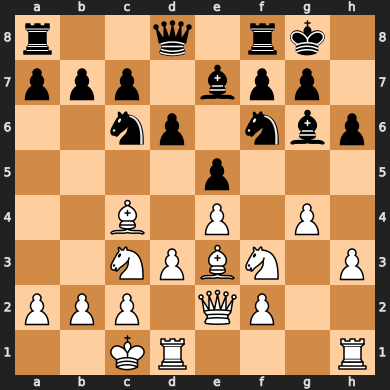

'blitz'

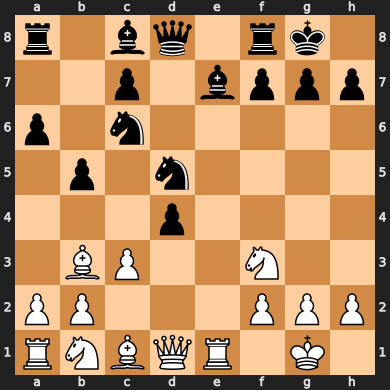

'blitz'

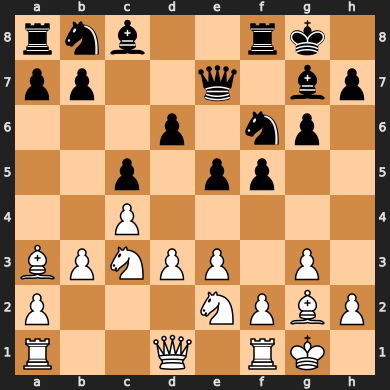

'crazyhouse'

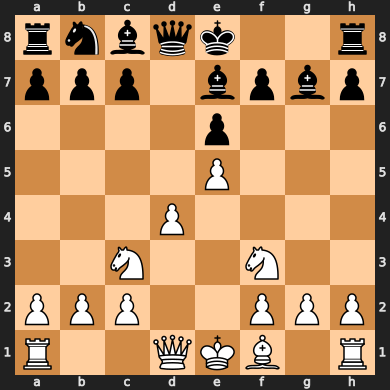

'crazyhouse'

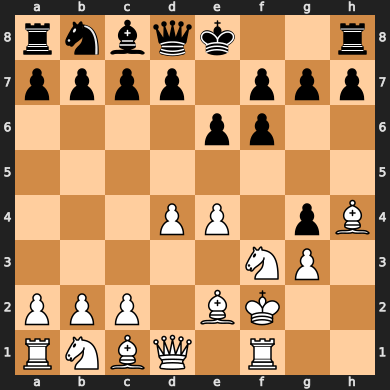

'crazyhouse'

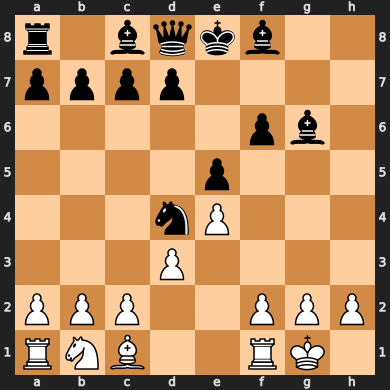

'chess960'

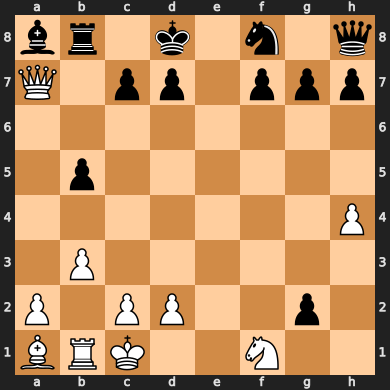

'chess960'

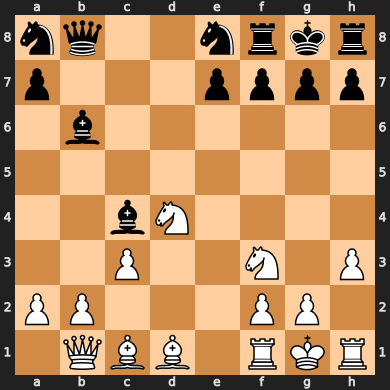

'chess960'

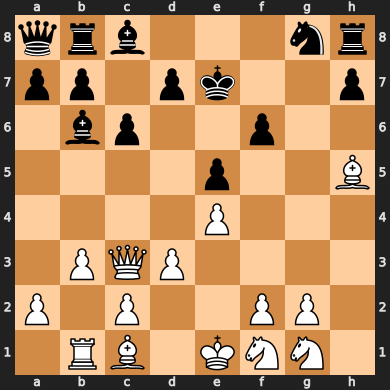

'kingOfTheHill'

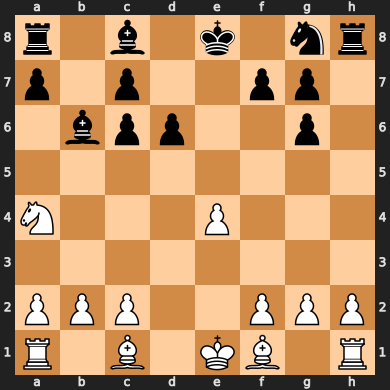

'kingOfTheHill'

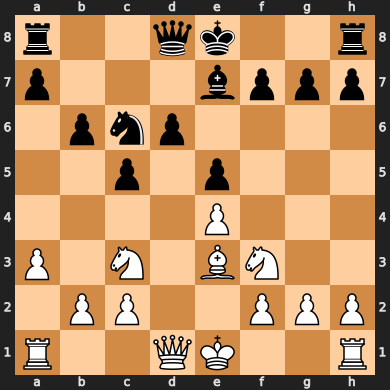

'kingOfTheHill'

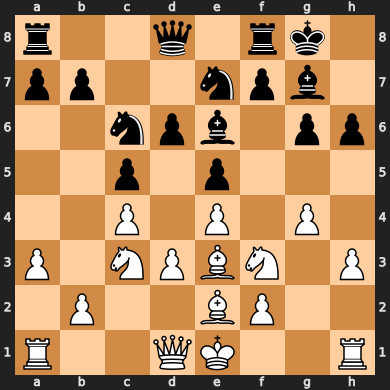

'threeCheck'

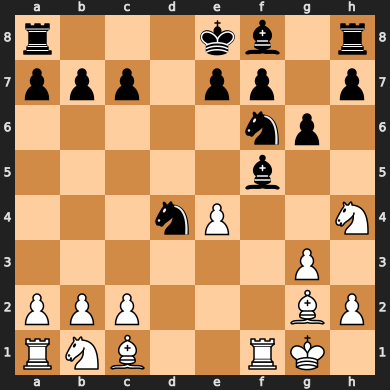

'threeCheck'

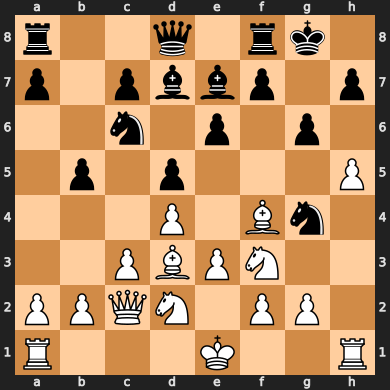

'threeCheck'

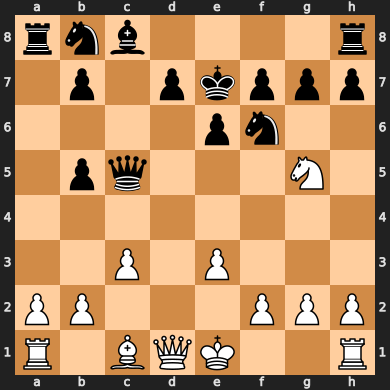

'antichess'

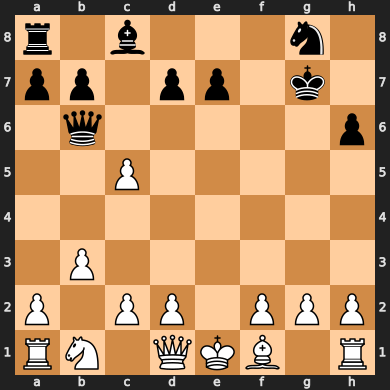

'antichess'

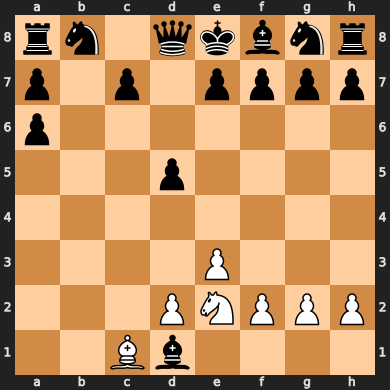

'antichess'

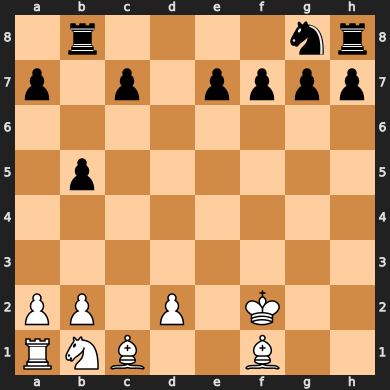

'atomic'

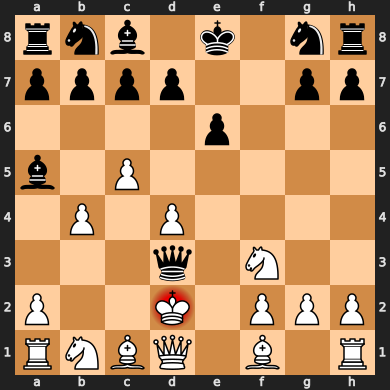

'atomic'

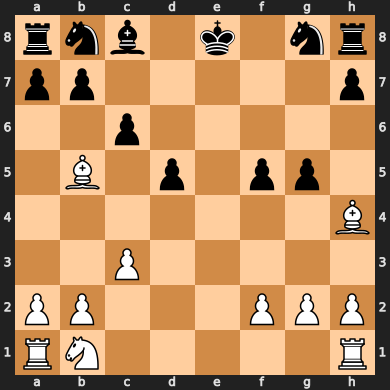

'atomic'

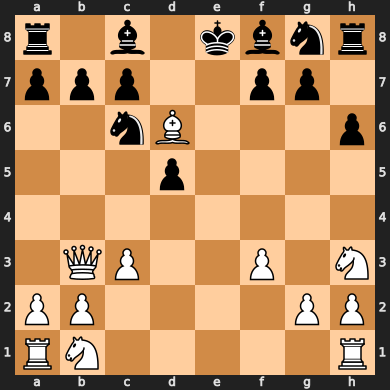

'horde'

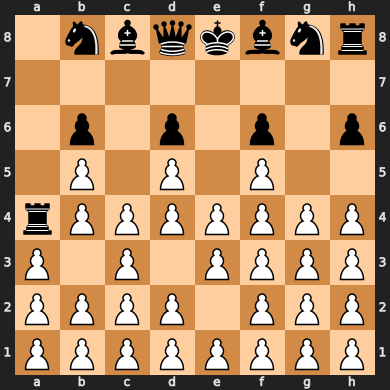

'horde'

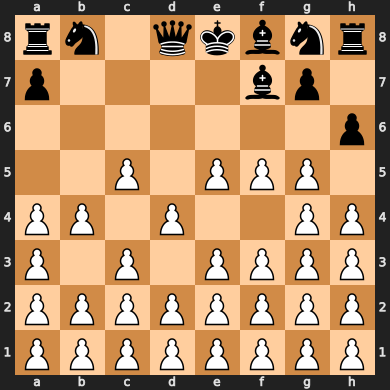

'horde'

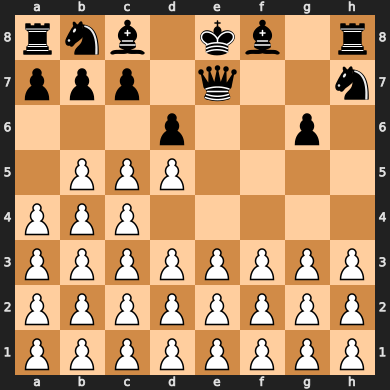

'racingKings'

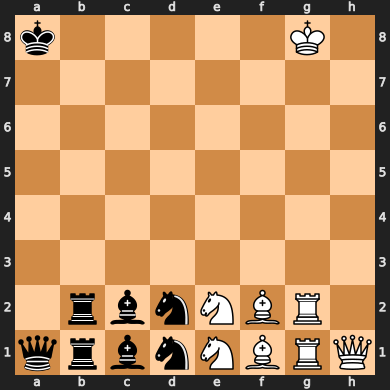

'racingKings'

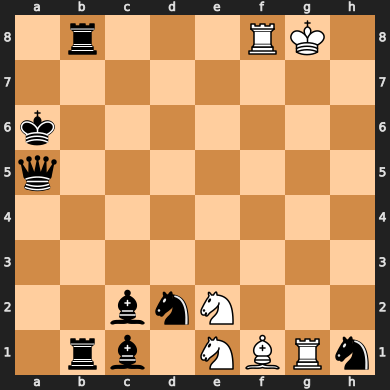

'racingKings'

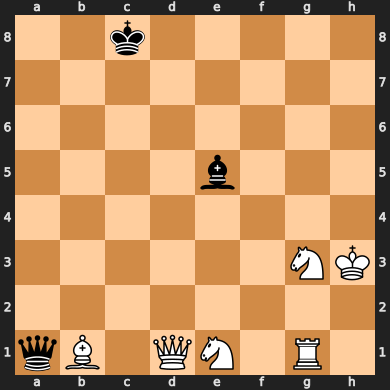

In [41]:
nb_pos = 3
for k in range(9):
    for i in np.random.randint(0+df.shape[0]/9*k, (df.shape[0]/9) * (1+k), nb_pos):  # random selection of games for each variant
        board = chess.Board(df['position'][i])
        display(df['variant'][i],board)

Based on the different positions that have been plotted and some domain knowledge, intuition and creativity, we can create features that might help to predict the variant.  
We also try to give a rational that might explain why a certain feature should be useful. 

## Feature engineering <a class="anchor" id="eng"></a>

The following features are going to be explored:    

- #### Number of moves
--> atomic: the nature of the game might favour "explosive" and quick games  
--> threeCheck, racingKings, KingOfTheHill: the rules of the game present the possibility for a game to end if a certain condition is met (3 checks / King on the 8th row / King in the center)

- #### Number of pieces traded
--> antichess, atomic: the rules of the game favour exchanges   
--> threeCheck: the nature of the game might lead player to sacrifice pieces (for instance to deviate a piece, remove a defender) to be able to give more checks  
--> racingKings: the initial position favours many exchanges

- #### Number of Kings on the board
--> horde: White has no King  
--> antichess, atomic: Both players can "lose" their King  

- #### Number of pawns on the board
--> horde: white plays with 36 pawns at the beginning  
--> racingKings: both player have no pawns at the beginning  
--> antichess: the nature of the game might favour many exchanges and therefore less pawns

- #### Number of pieces of each type on the board
--> Crazychess: the player can "insert" piece on the board and there have more pieces that at the beginning of the game (--> the player can have 3 Knight, 2 Queens... which is extremely rare in other variants)   
--> Others: the different variants have their own specificities which affects the material present on the board


- #### Proportion of Kings having left the 1st row
--> racingKings, KingOfTheHill: the rules of the game encourage players to move their Kings forward
--> horde: White has no King  
--> antichess, atomic: Both players can "lose" their King

- #### Number of pieces that left the 1st row, per variant
--> racingKings: the original position favours many exchanges on the 1st row (pieces that are going to "leave" the 1st row at the same time they leave the chess board)  
--> chess960: the original positions being reshuffled, it might be more difficult for the player to develop their pieces

- #### Number of pawns in the 4 central squares of the board  
--> blitz, crazyhouse, threeChecks, KingOfTheHill: the strategy of the game encourages players to control the center of the board

- #### Analysis of the position of certain pieces on key squares  
--> chess960: the positionning at the beginning of the game is not the same, meaning that the pieces might not land on the critical squares

- #### Number of checks given  
--> threeChecks: the goal being to give checks, we can expect their number to be higher for threeChecks


### Features only for EDA, as the information is already included in the number of pieces of each type:
- #### Total "weight" of pieces for each player
--> All: the different variants have their own specificities which affects the material present on the board

- #### Total "weight" difference of pieces between players
--> All: the games might be more "imbalanced" in some variants than in others



Let's us start by computing the features that will be useful when we look at our data through different angles.  
We start by creating some squares of interest that will be analyzed in this EDA.  

In [42]:
# squares of interest that will be needed in the analysis
white_first_row = ['a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1']
black_first_row = ['a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8']
center = ['d4', 'd5', 'e4', 'e5']
ext_center = ['c4', 'c5', 'f4', 'f5']
third_row_c_f = ['c3', 'c6', 'd3', 'd6', 'e3', 'e6', 'f3', 'f6']
b_g_col = ['b3','b4', 'b5', 'b6', 'g3','g4', 'g5', 'g6']
knight_squares = ['c3', 'd2', 'e2', 'f3', 'c6', 'd7', 'e7', 'f6']
castle_squares = ['g1', 'c1', 'g8', 'c8']

We then create the features of interest that will be analyzed. These features result from an iterative process and are the summary of the features that will be included in the model (except specified otherwise later).  
Features that have been tested but that did not show a promising output are therefore not presented here.  

In [43]:
# counting the material on the board
df['nb_R'] = (df[chess.SQUARE_NAMES] == 'R').sum(axis=1)
df['nb_r'] = (df[chess.SQUARE_NAMES] == 'r').sum(axis=1)
df['nb_N'] = (df[chess.SQUARE_NAMES] == 'N').sum(axis=1)
df['nb_n'] = (df[chess.SQUARE_NAMES] == 'n').sum(axis=1)
df['nb_B'] = (df[chess.SQUARE_NAMES] == 'B').sum(axis=1)
df['nb_b'] = (df[chess.SQUARE_NAMES] == 'b').sum(axis=1)
df['nb_Q'] = (df[chess.SQUARE_NAMES] == 'Q').sum(axis=1)
df['nb_q'] = (df[chess.SQUARE_NAMES] == 'q').sum(axis=1)
df['nb_K'] = (df[chess.SQUARE_NAMES] == 'K').sum(axis=1)
df['nb_k'] = (df[chess.SQUARE_NAMES] == 'k').sum(axis=1)
df['nb_P'] = (df[chess.SQUARE_NAMES] == 'P').sum(axis=1)
df['nb_p'] = (df[chess.SQUARE_NAMES] == 'p').sum(axis=1)

# counting the number of captures that have occured in the games
def count_captures(list_moves):
    count = "".join(list_moves).count('x')
    return count
df['nb_captures'] = df['first_moves'].apply(count_captures)

# counting the total "weight" of the pieces of each player
# using the "usual" weights in chess: queen = 9, rook = 5, bishop/knight = 3, pawn = 1
df['white_weight'] = df['nb_Q']*9 + df['nb_R']*5 + df['nb_N']*3 + df['nb_B']*3 + df['nb_P'] * 1
df['black_weight'] = df['nb_q']*9 + df['nb_r']*5 + df['nb_n']*3 + df['nb_b']*3 + df['nb_p'] * 1
df['diff_weight'] = df['white_weight'] - df['black_weight']

# counting the number of Kings on their first row
df['w_king_1st_row'] = ((df[white_first_row] == 'K')).sum(axis=1)
df['b_king_1st_row'] = ((df[black_first_row] == 'k')).sum(axis=1)

# counting the pieces on their first row
df['w_nb_pieces_1st_row'] = ((df[white_first_row] == 'K') | (df[white_first_row] == 'Q') | (df[white_first_row] == 'R') | (df[white_first_row] == 'B') | (df[white_first_row] == 'N') | (df[white_first_row] == 'P')).sum(axis=1)
df['b_nb_pieces_1st_row'] = ((df[black_first_row] == 'k') | (df[black_first_row] == 'q') | (df[black_first_row] == 'r') | (df[black_first_row] == 'b') | (df[black_first_row] == 'n') | (df[black_first_row] == 'p')).sum(axis=1)

# creating new features to be inspected: total number of pieces standing on the given squares
sq = [center, ext_center, third_row_c_f, b_g_col]
sq_names =  ["center", "ext_center", "third_row_c_f", "b_g_col"]

for square, square_names in zip(sq, sq_names):
    df['nb_pieces_'+square_names] = ((df[square] == 'K') | (df[square] == 'Q') | (df[square] == 'R') | (df[square] == 'B') | (df[square] == 'N') | (df[square] == 'k') | (df[square] == 'q') | (df[square] == 'r') | (df[square] == 'b') | (df[square] == 'n') ).sum(axis=1)
    df['nb_pawns_'+square_names] = ((df[square] == 'P') | (df[square] == 'p')).sum(axis=1)

# counting the knights on typical "knight squares"
df['knight_squares'] = ((df[knight_squares] == 'N') | (df[knight_squares] == 'n')).sum(axis=1)

df['king_castle_squares'] = ((df[castle_squares] == 'K') |  (df[castle_squares] == 'k')).sum(axis=1)

# counting the number of checks that have been given in the games
def count_checks(list_moves):
    count = "".join(list_moves).count('+')
    return count
df['nb_checks'] = df['first_moves'].apply(count_checks)

We include these features to a new dataframe that contains all engineered features.

In [44]:
df_feat_eng = df[['variant', 'nb_moves', 
           'nb_K', 'nb_Q', 'nb_R', 'nb_B', 'nb_N', 'nb_P',
           'nb_k', 'nb_q', 'nb_r', 'nb_b', 'nb_n', 'nb_p',          
           'nb_captures', 'w_king_1st_row', 'b_king_1st_row', 'w_nb_pieces_1st_row', 'b_nb_pieces_1st_row',
           'nb_pawns_center', 'nb_pawns_ext_center', 'nb_pawns_third_row_c_f', 'nb_pawns_b_g_col',
           'nb_pieces_center', 'nb_pieces_ext_center', 'nb_pieces_third_row_c_f', 'nb_pieces_b_g_col',
           'knight_squares', 'king_castle_squares', 'nb_checks']]

In [45]:
df_feat_eng.head()

variant  nb_moves  nb_K  nb_Q  nb_R  nb_B  nb_N  nb_P  nb_k  nb_q  ...  \
0   blitz        10     1     1     2     2     2     8     1     1  ...   
1   blitz        10     1     1     2     2     1     8     1     1  ...   
2   blitz        10     1     1     2     2     2     7     1     1  ...   
3   blitz        10     1     1     2     2     2     7     1     1  ...   
4   blitz        10     1     1     2     2     2     7     1     1  ...   

   nb_pawns_ext_center  nb_pawns_third_row_c_f  nb_pawns_b_g_col  \
0                    1                       3                 1   
1                    1                       2                 2   
2                    0                       1                 0   
3                    0                       2                 0   
4                    2                       1                 1   

   nb_pieces_center  nb_pieces_ext_center  nb_pieces_third_row_c_f  \
0                 1                     1                        3   
1                 0                     0                        1   
2                 0                     0                        3   
3                 0                     0                        5   
4                 0                     0                        3   

   nb_pieces_b_g_col  knight_squares  king_castle_squares  nb_checks  
0                  0               3                    2          0  
1                  0               1                    2          0  
2                  1               2                    1          0  
3                  2               4                    2          0  
4                  0               4                    2          0  

[5 rows x 30 columns]

## Feature exploration <a class="anchor" id="explo"></a>

To begin with, we can have a look at our different features and how they interact together. 

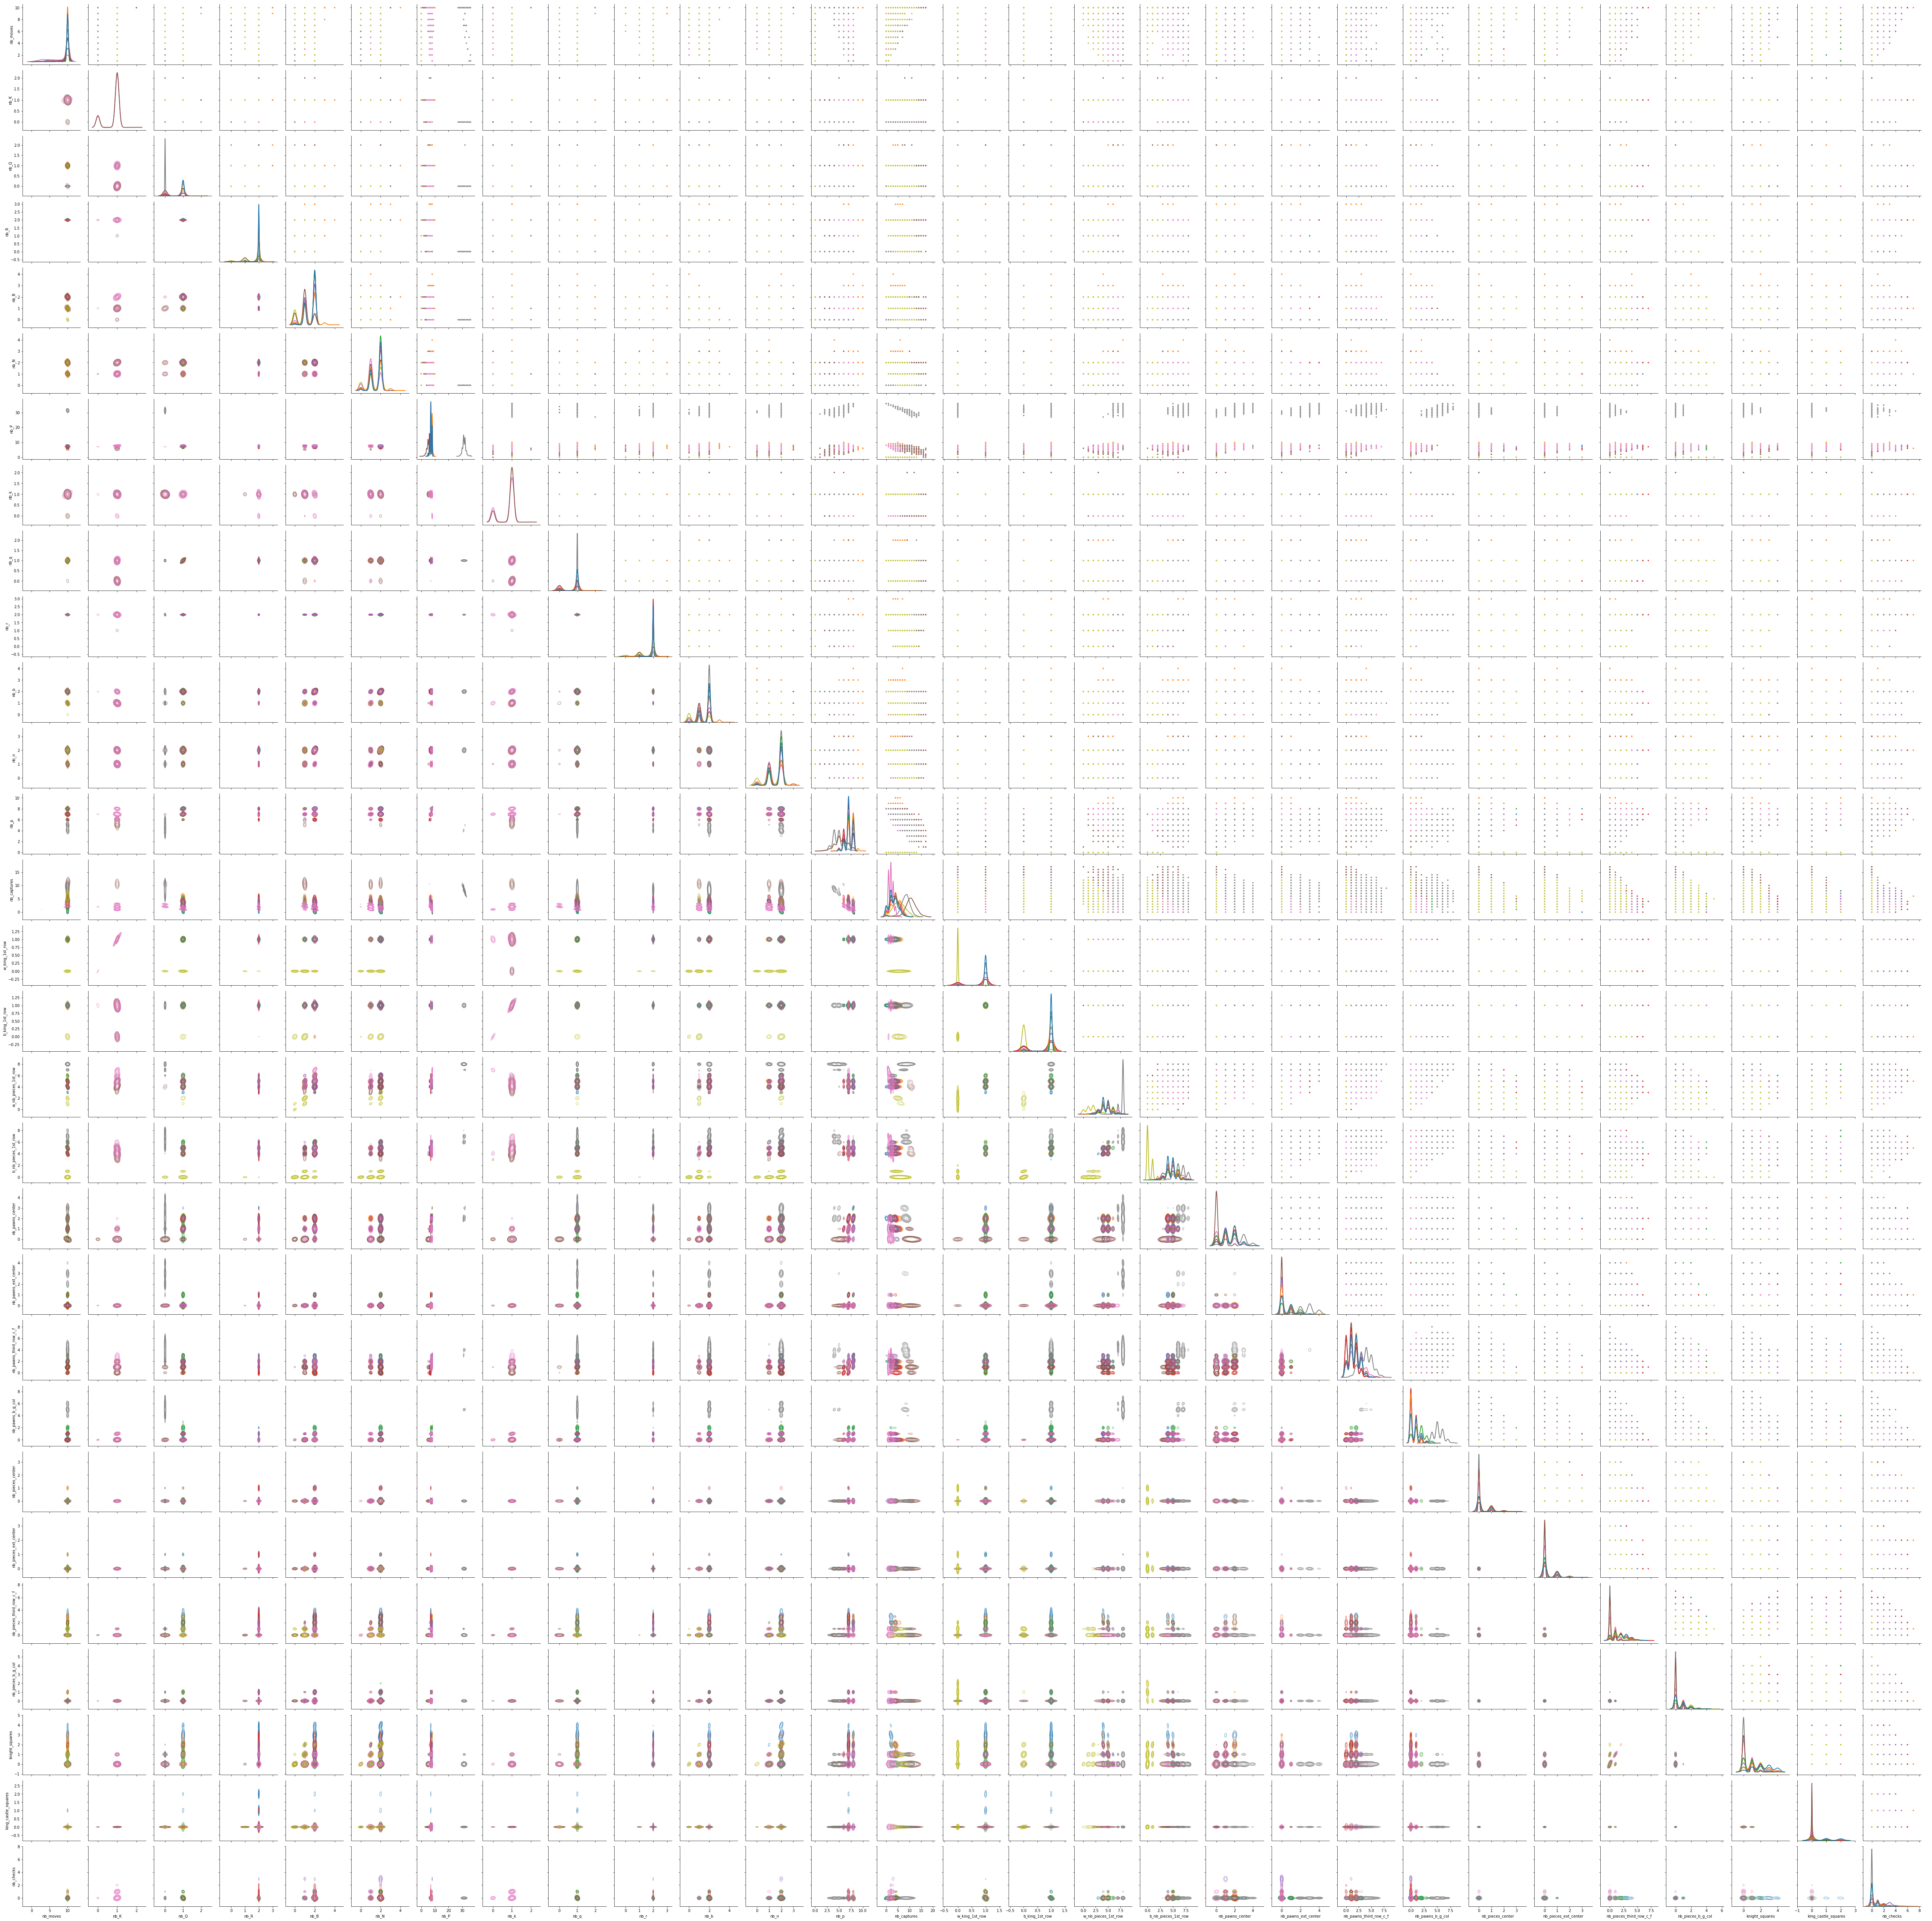

In [66]:
warnings.filterwarnings('ignore')
g = sns.PairGrid(df_feat_eng, hue="variant", diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot, thresh=0.5, alpha=0.5)
g.map_diag(sns.kdeplot, lw=2);

The graph is obvisouly difficult to read as the number of features is quite important. We can still see which features might play a big role in the analysis.  

Some interesting features are selected below.

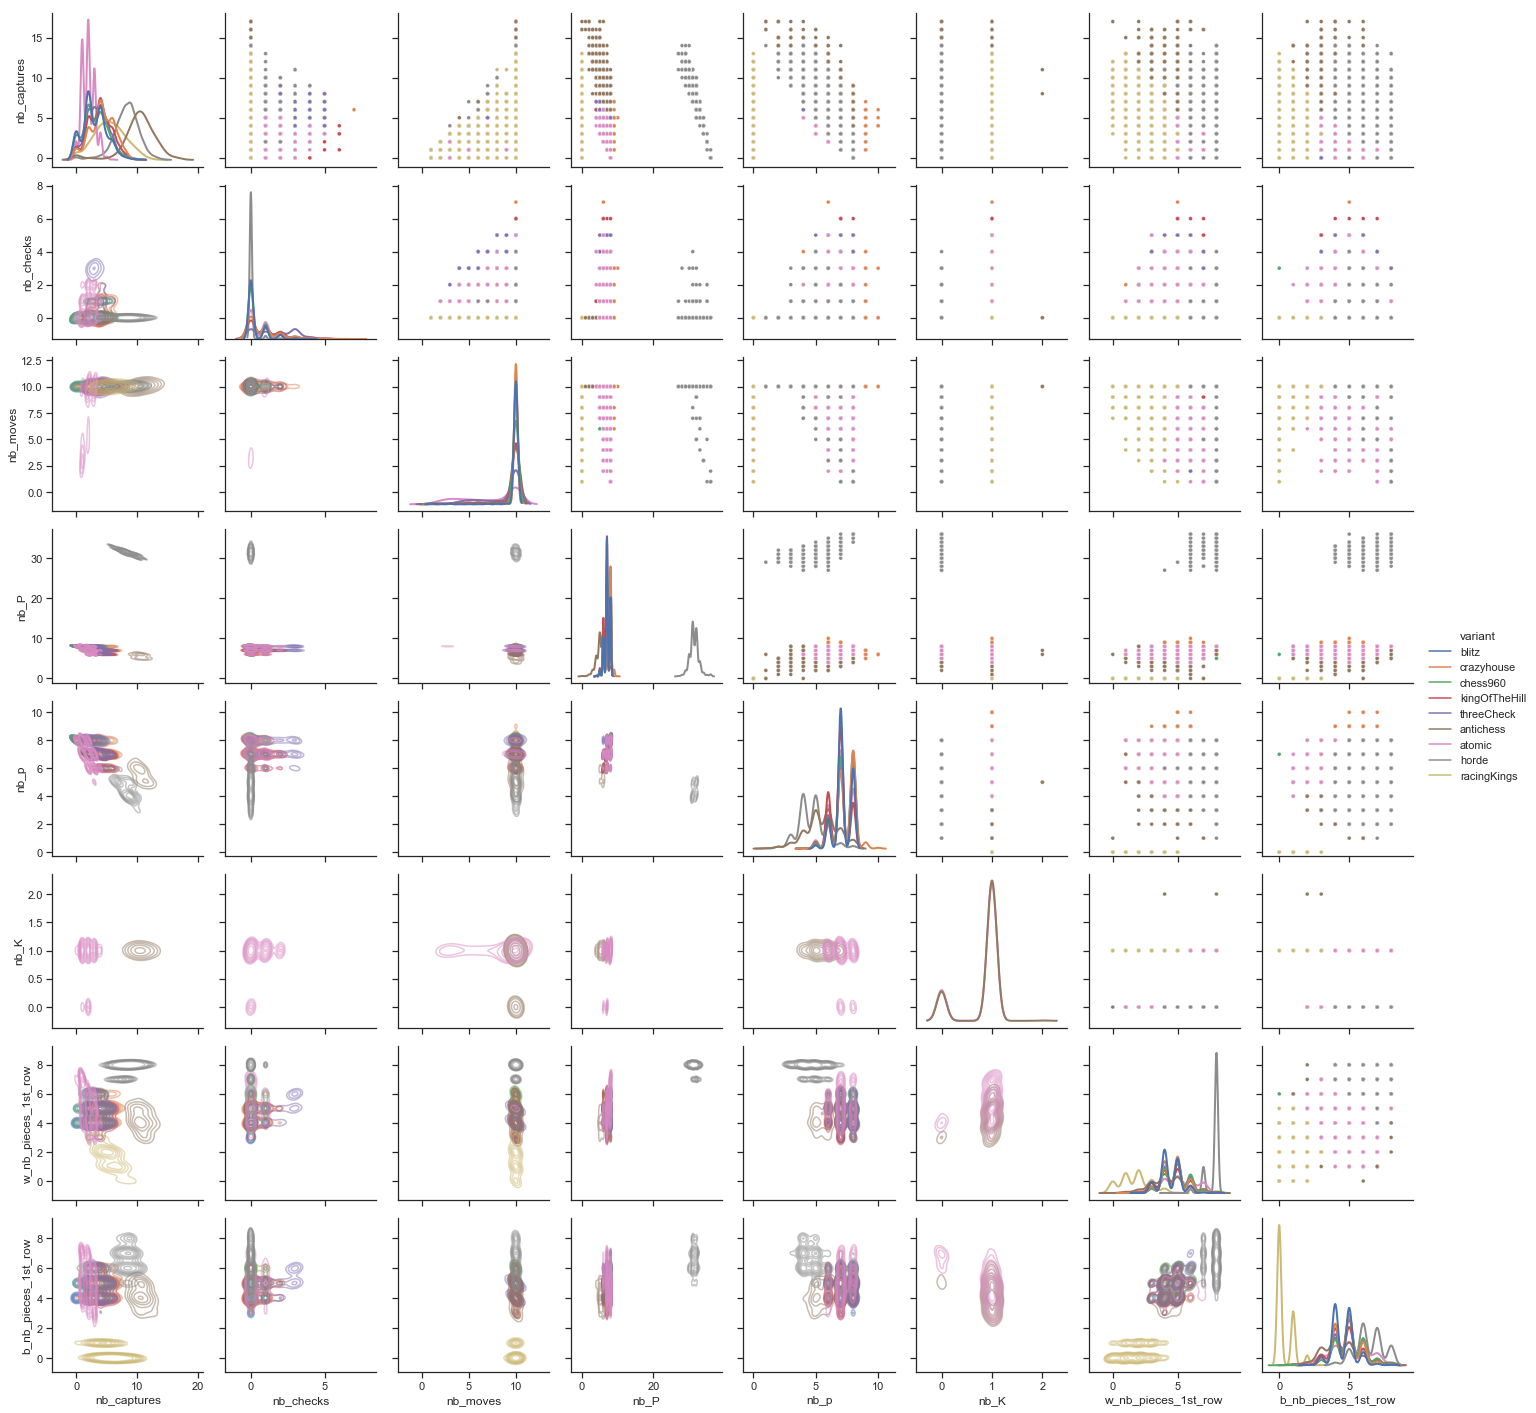

In [149]:
warnings.filterwarnings('ignore')
g = sns.PairGrid(df_feat_eng[['variant', 'nb_captures', 'nb_checks', 'nb_moves', 'nb_P', 'nb_p', 'nb_K', 'w_nb_pieces_1st_row', 'b_nb_pieces_1st_row']], hue="variant", diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot, thresh=0.3, alpha=0.5)
g.map_diag(sns.kdeplot, lw=2)
g = g.add_legend()

In [146]:
warnings.simplefilter('always') # reactivating warnings

On the upper right side of the graph can be found the scatterplots of the relations of each pairs of features. However, this view has the inconveniency for discrete features to "superpose" all points, which is not convenient to read. In addition, pairplots will show a point if there is an observation, but also if there are thousands of observations. 
The bottom left parts of the graph shows pair density plots, giving us the opportunity to see the areas in which the data is concentrated.  

We can clearly see that some features are correlated together. For instance, we can see that we have a positive relation between the number of moves and the number of checks as well as a negative relation between the number of pawns and the number of captures. Similarly, the more moves we have, the more captures we have, the less pieces are left on the board. 

Even more intersting is the observation that some features or combinations of features discriminate certain variants well. For instance, a high number of white pawns will already enable us to conclude that the variant played is horde, whatever the other features are like. A low number of black pieces on their first row is a great indicator that the variant might be the racingKings.  
In some cases, we see that combining two features also help to predict the variant. For instance, a low high number of captures and a low number of white pieces on the first row might be a good indicator that the variant is antichess. Similarly, a high number of checks and a low number of black pieces on the backrow might indicate that the variant is threeChecks.  
More generally, we can see patterns with some variants that should be very easy to predict like racingKings, horde, others a bit more complicated like threeCheck, chess960 and atomic and the rest of the variants that might be more challenging to predict. 

But as all presented features seem to play a role in our analysis, we are going to have a deeper look at each of them. 

## Number of moves

We start by plotting variable that we have already computed to see if they are relevant. The two first ones are linked and represent the proportion of games that have reached the Nth move as well as the average number of move reached by variant.

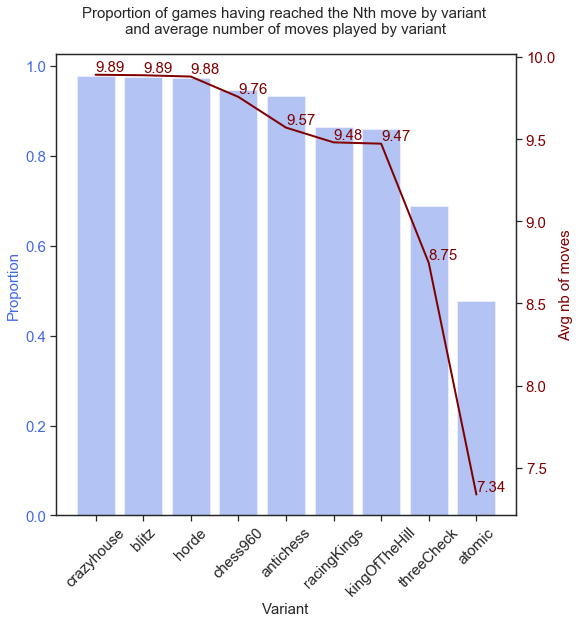

In [46]:
sns.set_theme(style="ticks")
fig, ax1 = plt.subplots(figsize=(8, 8))

plt.title("Proportion of games having reached the Nth move by variant \n and average number of moves played by variant ", fontsize=15, pad=20)

color1 = 'royalblue'
ax1.bar(df.groupby('variant')['moves_played_is_N'].sum().sort_values(ascending = False).index.values, df.groupby('variant')['moves_played_is_N'].mean().sort_values(ascending = False).values, color=color1, alpha=0.4)
ax1.set_xlabel('Variant',  fontsize=15)
ax1.set_ylabel('Proportion', color=color1,  fontsize=15)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=15)
plt.xticks(rotation='45', fontsize=15)

color2 = 'maroon'
ax2 = ax1.twinx()  # second y axis to share same x axis
ax2.set_ylabel('Avg nb of moves', color=color2, fontsize=15) 
ax2.plot(df.groupby('variant')['nb_moves'].sum().sort_values(ascending = False).index.values, df.groupby('variant')['nb_moves'].mean().sort_values(ascending = False).values, color=color2, linewidth=2)
for i, txt in enumerate(np.around(df.groupby('variant')['nb_moves'].mean().sort_values(ascending = False).values,2)):
    ax2.annotate(txt, (df.groupby('variant')['nb_moves'].mean().sort_values(ascending = False).index[i], df.groupby('variant')['nb_moves'].mean().sort_values(ascending = False).values[i]+0.02), size=15, color=color2)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=15)

fig.tight_layout()  
plt.subplots_adjust(left=0.1, right=0.9, top=1)
plt.show()

It is clear that the properties of atomic makes the game "explosive" and that more of half of the games end before move N.  
In addition, threeCheck and racingKings also tend to finish more quickly than the other variants. This is certainly due to the fact that many games end as soon as one player gives three checks or reach the final row with their Kings.   
Similarly, the game is ended in racingKings and kingOfTheHill when some condition is met (when the King reaches certain squares). This leads some games to end sooner.  
In antichess, more players might resign as antichess is very error prone and a single error can lead to the loss of the game. In chess960, there is no real "theory" and in some cases, an error can also lead to a resignation.  

Overall, we can imagine a lot of explanations to the observations. Even if we do not look at the variability of the variables here, it seems that the average number of moves played and the proportion of games reaching move N has an impact on the different variants.  
We want to include these variables in our predictve models.

## Number of pieces traded

We can also expect the number of pieces traded to be a distinctive elements for predicting the variant played.

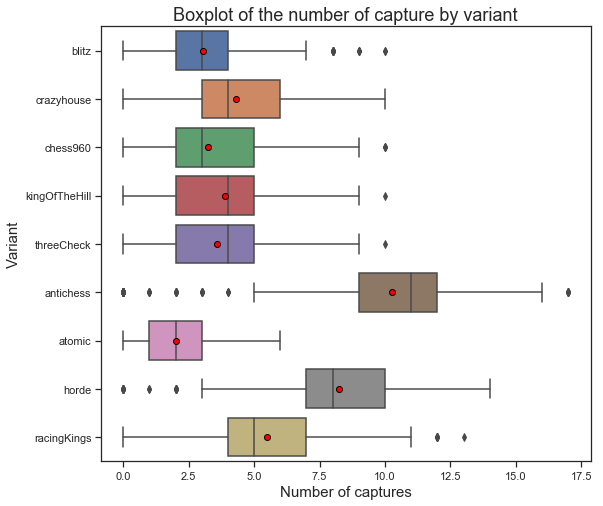

In [47]:
plt.subplots(figsize=(8, 8))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x='nb_captures', y='variant', order = variants, data=df, showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"})
ax.set_title("Boxplot of the number of capture by variant", fontsize=18)
ax.set_xlabel('Number of captures', fontsize=15)
ax.set_ylabel('Variant', fontsize=15)
plt.subplots_adjust(left=0.05);

Without any surprise, antichess presents much more trades than any other variant. This is the result of the rules of the game that force the players to capture the pieces of the oponent if any piece can be taken.  
Horde also shows a higher median score, which is not surprising giving the high number of pawns that white has at the beginning of the game.  
On the opposite side, we see that atomic shows less captures. This is somehow unexpected, but can easily be explained by the fact that a captures removes multiple pieces from the board, which makes further captures less likely.  

Again, we want to include this variable in our analysis.  

## Number of Kings on the board

The rules of the game also can have an impact on the number of Kings. Most of the variant impose that both players have a King.  
However, in antichess, atomic and horde, this rule is not existing.

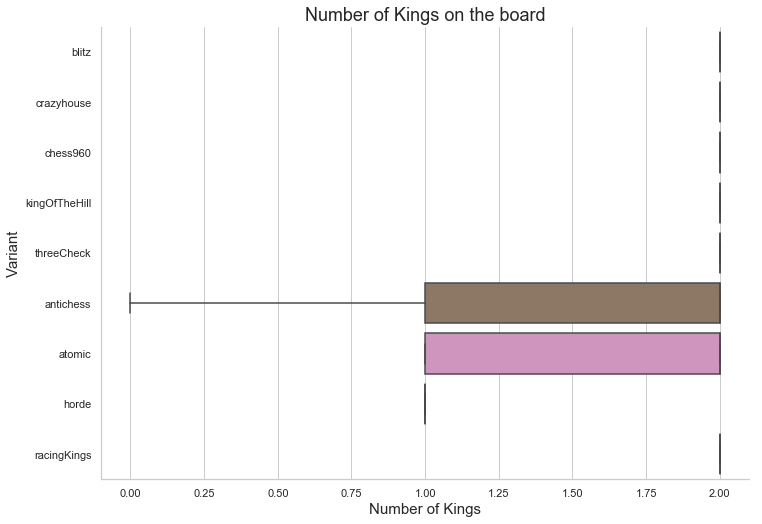

In [48]:
df_prep = pd.concat([df["nb_K"] + df["nb_k"], df['variant']], axis=1)
df_prep.columns=["nb_kings", "variant"]
plot=sns.catplot(x="nb_kings", y="variant", kind="box", order = variants,  data = df_prep, height = 7, aspect=1.5)
axis=plot.axes.flatten()
axis[0].set_title("Number of Kings on the board", fontsize=18)
axis[0].set_ylabel("Variant", fontsize=15)
axis[0].set_xlabel("Number of Kings", fontsize=15);

The graph confirms the assumptions. 

We see also that in atomic, there is either one or two Kings on the board (the game ends when a player loses its King).  
We can continue the analysis on the three variants and split it by color.

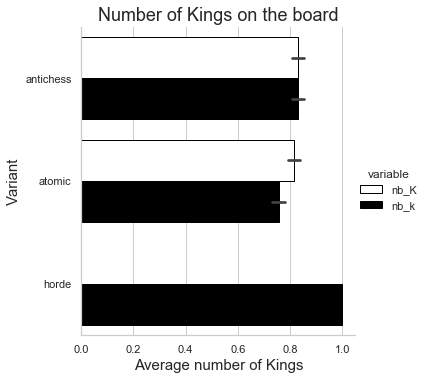

In [49]:
df_melt = df[["variant", "nb_K", "nb_k"]].melt(id_vars='variant')
plot=sns.catplot(x="value", y="variant", hue="variable", kind="bar", palette=["white", "black"], edgecolor= "black", data = df_melt[((df_melt['variant'] == 'antichess') | (df_melt['variant'] == 'atomic') | (df_melt['variant'] == 'horde'))], height=5)
axis=plot.axes.flatten()
axis[0].set_title('Number of Kings on the board', fontsize=18)
axis[0].set_xlabel('Average number of Kings', fontsize=15)
axis[0].set_ylabel('Variant', fontsize=15);

We see that in horde, white never has any King but black always have one. This is not the case for antichess and atomic where both players can have a King or not.  
In every case, we want to include this information in our models. 

## Number of pawns on the board

When plotting the different diagrams of random positions for each variant, we saw that the number of pawns also has a significant impact for some of them. Let's explore this track a little more.

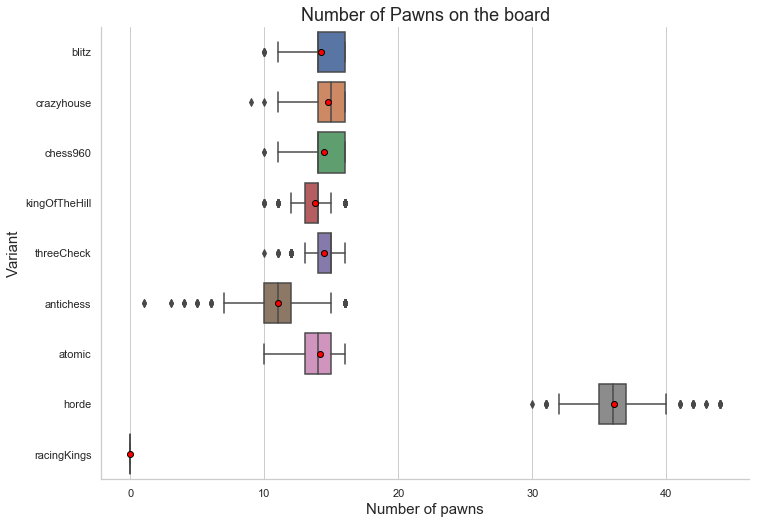

In [50]:
df_prep = pd.concat([df["nb_P"] + df["nb_p"], df['variant']], axis=1)
df_prep.columns=["nb", "variant"]
plot=sns.catplot(x="nb", y="variant", kind="box", order = variants,  data = df_prep, height = 7, aspect=1.5, showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"})
axis=plot.axes.flatten()
axis[0].set_title("Number of Pawns on the board", fontsize=18)
axis[0].set_ylabel("Variant", fontsize=15)
axis[0].set_xlabel("Number of pawns", fontsize=15);

It is clear that the number of pawns is a great disciminant feature between the different variants.

More generally, the number of any piece might have a role to play in our analysis.  

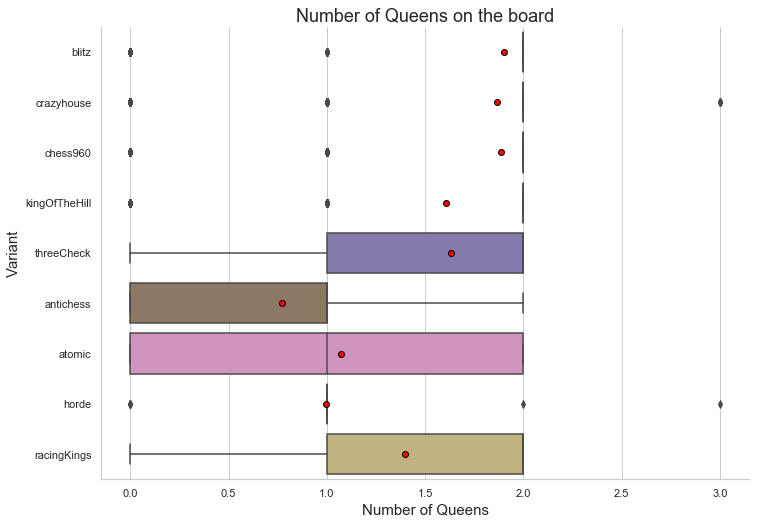

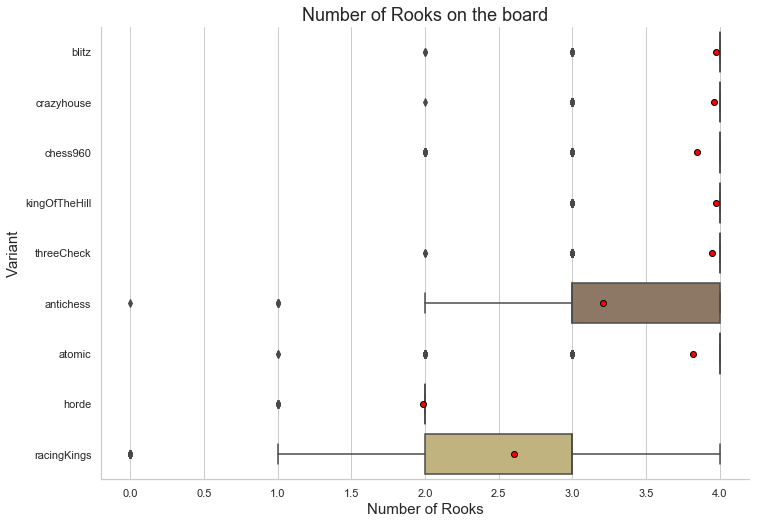

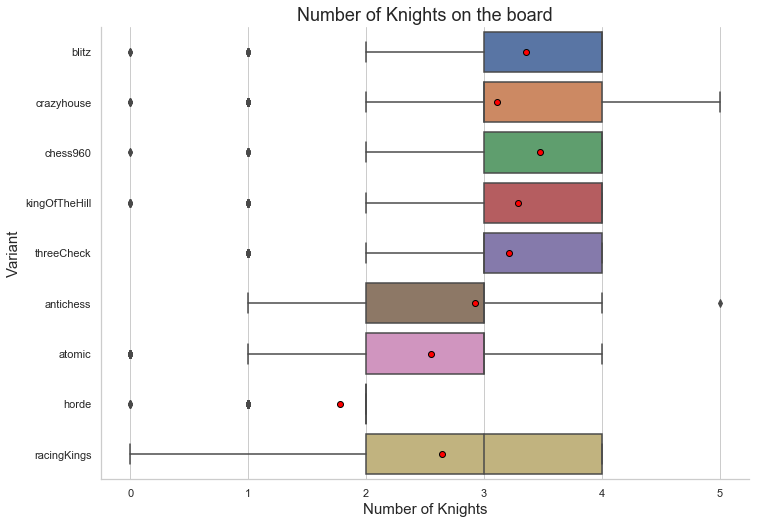

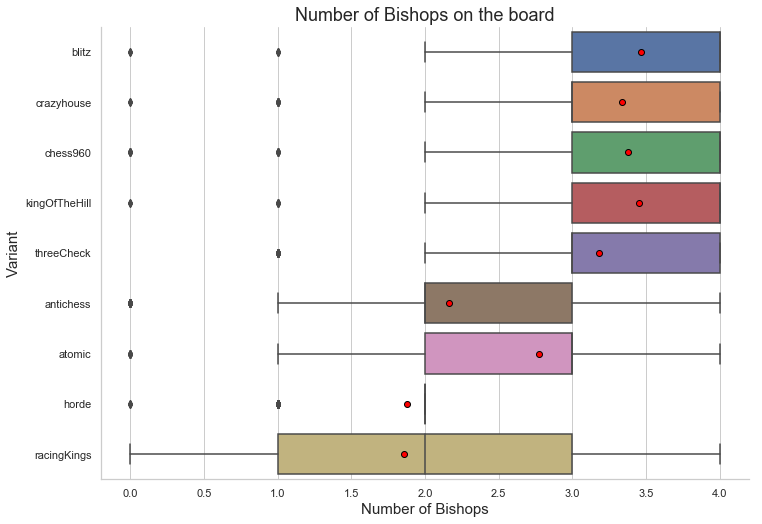

In [51]:
for fig, fig_name in zip(['Q','R','N', 'B'],['Queens','Rooks','Knights', 'Bishops']):    
    df_prep = pd.concat([df["nb_"+fig] + df["nb_"+fig.lower()], 
                         df['variant']], axis=1)
    df_prep.columns=["nb_fig", "variant"]
    plot=sns.catplot(x="nb_fig", y="variant", kind="box", order = variants,  data = df_prep, height = 7, aspect=1.5, showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"})
    axis=plot.axes.flatten()
    axis[0].set_title("Number of " + fig_name + " on the board", fontsize=18)
    axis[0].set_ylabel("Variant", fontsize=15)
    axis[0].set_xlabel("Number of " + fig_name, fontsize=15);

We include these features in our analysis as they all might help the model to figure out relevant pattern from the model more easily.  
We can have a look at the total number of pieces present on the board as well.

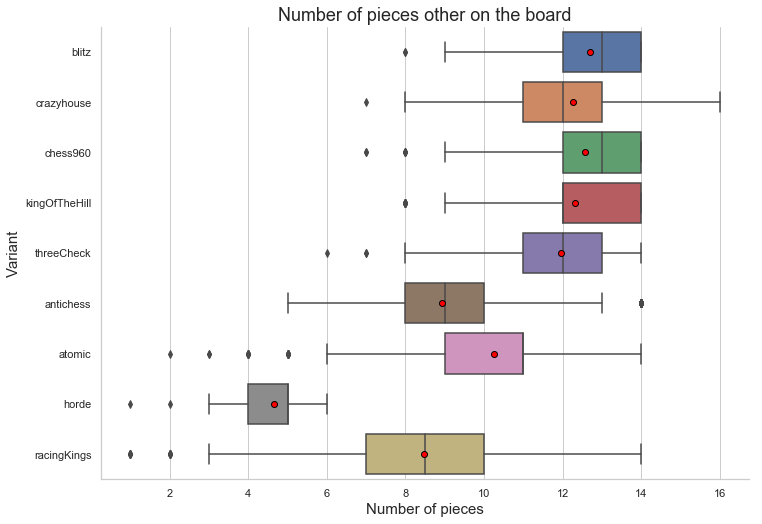

In [52]:
df_prep = pd.concat([df["nb_Q"] + df["nb_q"] +
                     df["nb_R"] + df["nb_R"] +
                     df["nb_N"] + df["nb_n"] +
                     df["nb_B"] + df["nb_b"], 
                     df['variant']], axis=1)
df_prep.columns=["nb", "variant"]
plot=sns.catplot(x="nb", y="variant", kind="box", order = variants,  data = df_prep, height = 7, aspect=1.5, showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"})
axis=plot.axes.flatten()
axis[0].set_title("Number of pieces other on the board", fontsize=18)
axis[0].set_ylabel("Variant", fontsize=15)
axis[0].set_xlabel("Number of pieces", fontsize=15);

Simiarly, we can have a look at the "weight" of all the pieces on the board for each player, to see if we can notice some unbalances between the different variants.

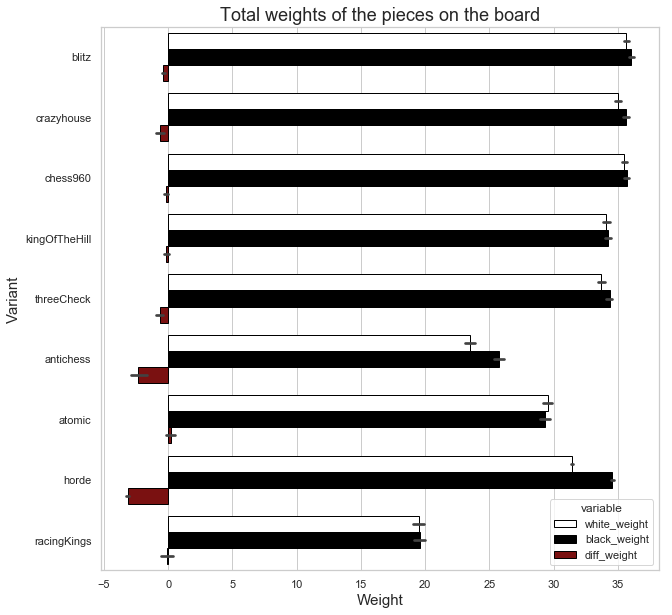

In [53]:
fig, ax1 = plt.subplots(figsize=(10, 10))
df_melt = df[["variant", "white_weight", "black_weight", "diff_weight"]].melt(id_vars='variant')
sns.barplot(x='value', y='variant', hue='variable', order = variants, data=df_melt, ax=ax1, palette=["white", "black", "darkred"], edgecolor= "black")
ax1.set_title('Total weights of the pieces on the board', fontsize=18)
ax1.set_xlabel('Weight', fontsize=15)
ax1.set_ylabel('Variant', fontsize=15);

The last two graphs confirm that the number of pieces on the board as well as their relative weights have an importance in the analysis. It is also possible to observe that the variation of the weight on the board is much bigger for certain variants (for instance atomic or antichess and much lower for other like horde).  
This gives us more knowledge about our data and might have given us further ideas of features to implement, but they do not add anything to the analysis as the information is already contained in the other variables.  
We do not want to include these features in the dataset.

In [54]:
df=df.drop(['white_weight', 'black_weight', 'diff_weight'], axis=1)

## Total number of checks given

We can also expect the number of checks given thave an impact for predicting the variant played.

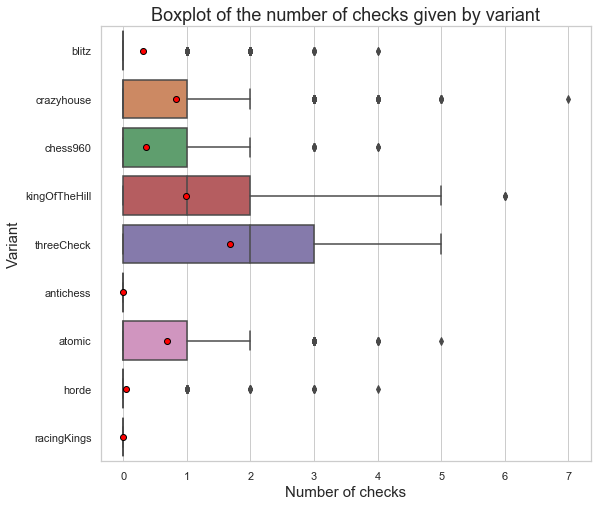

In [74]:
plt.subplots(figsize=(8, 8))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x='nb_checks', y='variant', order = variants, data=df, showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"})
ax.set_title("Boxplot of the number of checks given by variant", fontsize=18)
ax.set_xlabel('Number of checks', fontsize=15)
ax.set_ylabel('Variant', fontsize=15)
plt.subplots_adjust(left=0.05);

Again, we can observe a contrast in the different variants and we include this variable. Wihout any surprise, threeCheck presents the more checks as the goal of the player is to give as many as possible (and it is easier to give a check than to counter one, increasing the total number of checks).

## Further exploration <a class="anchor" id="further"></a>

At this stage of the analysis, we have included features relative to the number of moves, of trades or more generally of the total number of pieces on the board.   
We have been able to observe that these features should enable to differentiate well some variants from others.  
However, the variants that can be easily differentiated are often the same:  
- horde  
- racingKings  

This can be explained by the inital position and the rules that differ drastically from the others variants. However, some variants might be less challenging to predict as we have seen that many features might discriminate them well:  
- antichess  
- atomic  
- chess960 (to a certain extent)  

And some variant might be more difficult to predict:  
- (chess960) 
- blitz   
- crazyhouse  
- kingOfTheHill  
- threeCheck  

Indeed, in these last variants, the initial position is the same (except for chess960, even if still somehow similar in the sense that pieces are in the first row and pawns on the second one). We should therefore focus more on the development of the game and on strategies that player might adopt.  
Thus, we will now focus on certain strategic squares that might have a significant impact in some of the variants or on game developments that we could expect to see.  

We will as well focus the analysis on these last variants which require more interest.

In [61]:
var_of_interest = ['blitz', 'chess960', 'crazyhouse', 'kingOfTheHill', 'threeCheck']

As a reminder, the squares that will be considered are given below:


## Proportion of Kings on their 1st row

In kingOfTheHill (and racingKings), the goal for the player is to move the King forward. We can expect these variants to have only few Kings still on the backrow.  
For other variants, we can also expect the strategy of the games to lead to certain behaviours regarding the Kings. Let's explore it!

In [62]:
df_melt = df[["variant", "w_king_1st_row", "b_king_1st_row"]][df["variant"].isin(var_of_interest)].melt(id_vars='variant')

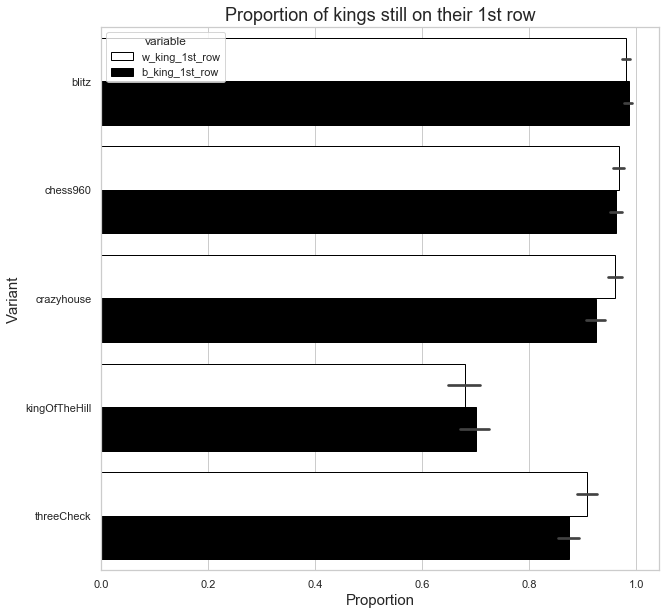

In [63]:
fig, ax1 = plt.subplots(figsize=(10, 10))
df_melt = df[["variant", "w_king_1st_row", "b_king_1st_row"]][df["variant"].isin(var_of_interest)].melt(id_vars='variant')
sns.barplot(x='value', y='variant', hue='variable', order = var_of_interest, data=df_melt, ax=ax1, palette=["white", "black"], edgecolor= "black")
ax1.set_title('Proportion of kings still on their 1st row', fontsize=18)
ax1.set_xlabel('Proportion', fontsize=15)
ax1.set_ylabel('Variant', fontsize=15);

<!--- racingKings behaves as expected as most of the players have moved their King forward.  -->
The goal being to reach the center of the board with the King, we see a much lower proportion of Kings still on the backrank for racingKings.  
Another interesting observation is that in threeChecks and crazyhouse, the Kings might sometimes leave their first row, potentially due by the fact that the opponent player might be ready to sacrifice pieces to gain another advantage like the opponent's King weakness (a sacrifice of a piece that has to be taken by the opponent's King) which is extremely important in these aggressive variants.   
Obviously, we include this new feature in our analysis as it helps to disciminate variants such as the kingOftheHill, or even the crazyhouse and threechecks to a certain extent.  

<!--- Surprisingly, we see that in antichess, this proportion is also quite low compared to the other variants. This can be explained in two ways. The first is that the King might not be on the board anymore, the second is that the player might be forced to move forward the King if the opponent "gives" a piece to capture o the King. In such a case, the King is forced to capture this piece and to move forward.  
Similarly, in atomic, the King is removed from the board when checkmated and the game ends. Let's have a deeper look at these two variants by selecting only the games where both Kings are present on the board. -->

## Number of pieces that left their 1st row

Similarly, we can look at the total number of pieces that left the board. In chess960, as the pieces are set differently in the beginning, we can expect the players to have more difficulties to develop them. 

In [64]:
df_melt = df[["variant", "w_nb_pieces_1st_row", "b_nb_pieces_1st_row"]][df["variant"].isin(var_of_interest)].melt(id_vars='variant')

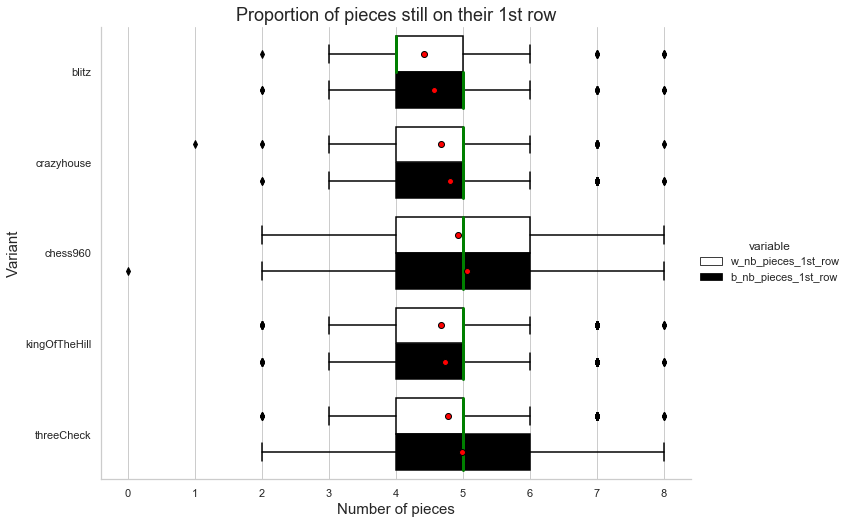

In [65]:
plot=sns.catplot(x="value", y="variant", hue="variable", kind="box",  height = 7, aspect=1.4, data=df_melt, medianprops={"linestyle":'solid', "linewidth":3, "color":'green'} , palette=["white", "black"], showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"})
axis=plot.axes.flatten()
axis[0].set_title('Proportion of pieces still on their 1st row', fontsize=18)
axis[0].set_xlabel('Number of pieces', fontsize=15)
axis[0].set_ylabel('Variant', fontsize=15);

We can  see that in chess960, more pieces seem to stay on the original row on average. But the dispertion of the data is clearly increased due to the randomness of the original position.  
This is definitely a variable we want to include as it is the first one we explore that might indicate some sort of dissimilarity for chess960 when compared to the other variants.

## Number of pieces in the central squares

In all of the variants, the control of the central squares is primordial. We can expect the players to fight for it more is some variants than in others. After looking at multiple "sets of squares" to see if we can find some patterns, the main ones are presented below.    
Similarly, the control of the center can be defined in multiple ways. We consider the control by pieces of by pawns standing on the given squares.

Let's start by looking at the different pieces that can occupy the given squares.

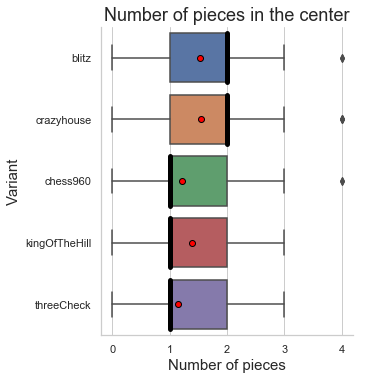

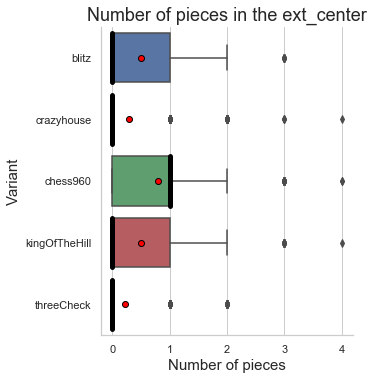

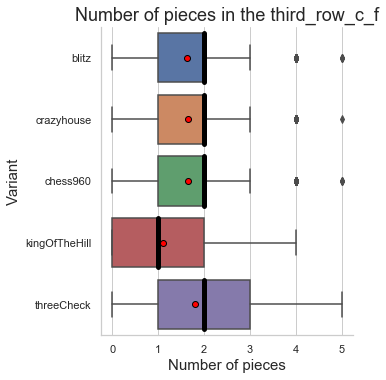

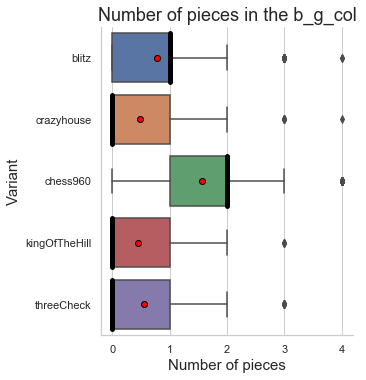

In [66]:
for square, square_names in zip(sq, sq_names):
    plot=sns.catplot(x=df['nb_pawns_'+square_names], y="variant", kind="box",  data=df[df["variant"].isin(var_of_interest)], showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"}, medianprops={"linestyle":'solid', "linewidth":5, "color":'black'})
    axis=plot.axes.flatten()
    axis[0].set_title('Number of pieces in the ' + square_names, fontsize=18)
    axis[0].set_xlabel('Number of pieces', fontsize=15)
    axis[0].set_ylabel('Variant', fontsize=15);

Similarly, let's look at the pawns standing on these key squares.

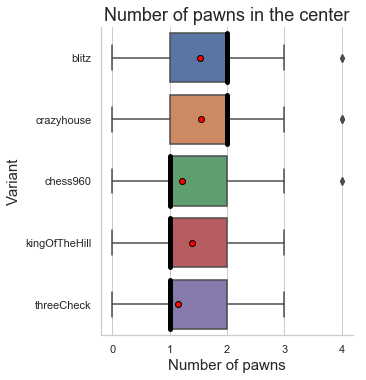

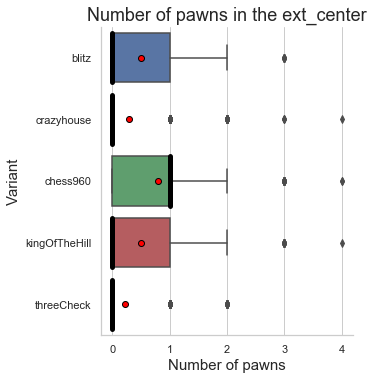

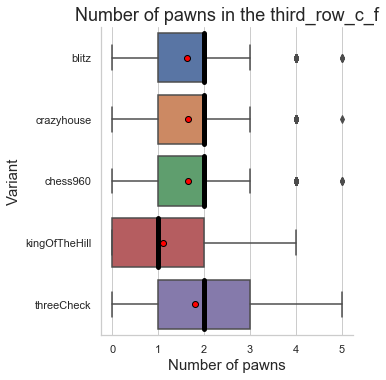

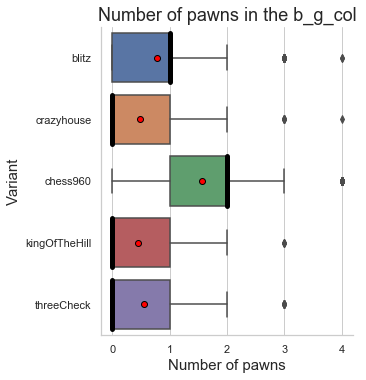

In [67]:
for square, square_names in zip(sq, sq_names):
    plot=sns.catplot(x=df['nb_pawns_'+square_names], y="variant", kind="box",  data=df[df["variant"].isin(var_of_interest)], showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"}, medianprops={"linestyle":'solid', "linewidth":5, "color":'black'})
    axis=plot.axes.flatten()
    axis[0].set_title('Number of pawns in the ' + square_names, fontsize=18)
    axis[0].set_xlabel('Number of pawns', fontsize=15)
    axis[0].set_ylabel('Variant', fontsize=15);

To a certain extent, all these features might help the models to extract relevant patterns as we see that there is some sources of differences between the variants.

## Position of knigths

An other interesting angle to look at the data is to consider the position of the knights. Indeed, in blitz, the knights usually are developped on the following squares: 

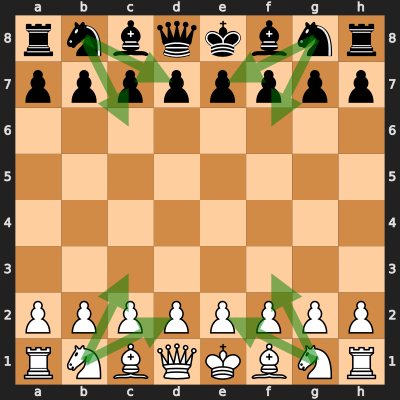

In [68]:
chess.svg.board(board = chess.Board(), arrows = ([chess.svg.Arrow(chess.B1, chess.C3, color = "green"), 
                                                  chess.svg.Arrow(chess.B1, chess.D2, color = "green"), 
                                                  chess.svg.Arrow(chess.G1, chess.E2, color = "green"), 
                                                  chess.svg.Arrow(chess.G1, chess.F3, color = "green"),
                                                  chess.svg.Arrow(chess.G8, chess.F6, color = "green"),
                                                  chess.svg.Arrow(chess.G8, chess.E7, color = "green"), 
                                                  chess.svg.Arrow(chess.B8, chess.D7, color = "green"), 
                                                  chess.svg.Arrow(chess.B8, chess.C6, color = "green")]), size=400)

However, in chess960, the intial position of the knights might be different and the knights would therefore stand "less often" on these squares than in the other variants.  
In the example below, only half (4 out of previous 8) of the squares mentioned might see a knight on them afer their first movement.   

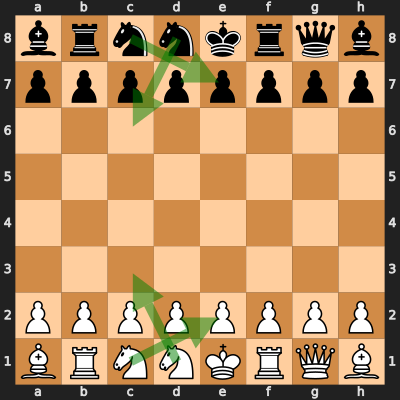

In [69]:
chess.svg.board(board = chess.Board('brnnkrqb/pppppppp/8/8/8/8/PPPPPPPP/BRNNKRQB w KQkq - 0 1'), arrows = ([chess.svg.Arrow(chess.D1, chess.C3, color = "green"), 
                                                                                                            chess.svg.Arrow(chess.C1, chess.E2, color = "green"),
                                                                                                            chess.svg.Arrow(chess.D8, chess.C6, color = "green"),
                                                                                                            chess.svg.Arrow(chess.C8, chess.E7, color = "green"),]), size=400)

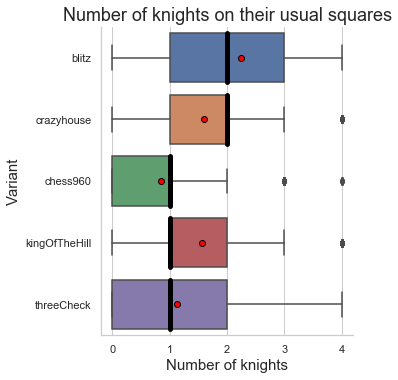

In [70]:
plot=sns.catplot(x=df['knight_squares'], y="variant", kind="box",  data=df[df["variant"].isin(var_of_interest)], showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"}, medianprops={"linestyle":'solid', "linewidth":5, "color":'black'})
axis=plot.axes.flatten()
axis[0].set_title("Number of knights on their usual squares", fontsize=18)
axis[0].set_xlabel('Number of knights', fontsize=15)
axis[0].set_ylabel('Variant', fontsize=15);

We see that blitz (from where the idea of using these squares came) indeed present the biggest number of knights on these squares. Chess960 also shows as expected the lowest number of knights on the concerned squares. The good news concerns the other variants that also seem to present less knights on the usual squares.  
This is good news as it is the first feature that seems to discriminate blitz from the rest of the variants.

## Position of Kings

Similarly, with the same idea, we can expect the Kings to castle and to land on their "regular" castling squares. But the strategies in some variants might differ and the player might prefer not to castle (for instance in kingOfTheHill where the player has to bring the King to the center) or to castle the latest possible (strategy commonly used in chess960 to "surprise" the opponent).

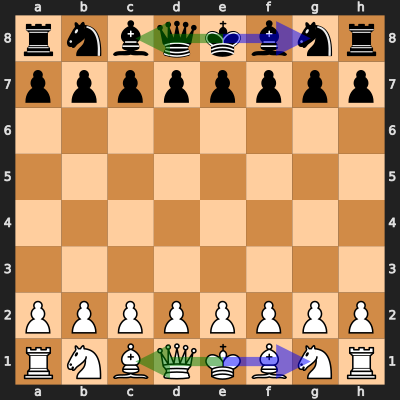

In [71]:
chess.svg.board(board = chess.Board(), arrows = ([chess.svg.Arrow(chess.E1, chess.G1, color = "blue"), 
                                                  chess.svg.Arrow(chess.E1, chess.C1, color = "green"), 
                                                  chess.svg.Arrow(chess.E8, chess.G8, color = "blue"), 
                                                  chess.svg.Arrow(chess.E8, chess.C8, color = "green")]), size=400)

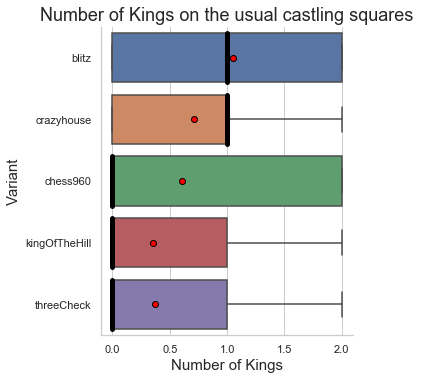

In [72]:
plot=sns.catplot(x=df['king_castle_squares'], y="variant", kind="box",  data=df[df["variant"].isin(var_of_interest)], showmeans=True, meanprops= {"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"}, medianprops={"linestyle":'solid', "linewidth":5, "color":'black'})
axis=plot.axes.flatten()
axis[0].set_title("Number of Kings on the usual castling squares", fontsize=18)
axis[0].set_xlabel('Number of Kings', fontsize=15)
axis[0].set_ylabel('Variant', fontsize=15);

Again, we see that it might be interesting to include this features in the analysis.

The previous EDA gave us strong insights on the features that might have a significant impact on the variant played.  
In an iterative process, multiple features have been explored and the best ones have been selected, presented and will now be integrated in the modelling part.  
We therefore save the dataframes of interest. 

# Saving the dataframes <a class="anchor" id="df"></a>

From the analysis, we came up with different sets of features.  
The "engineered" features were based on the position and on the moves that have been played on the board. We can count 29 of them. 
The "augmented" features are 448 binary features that represent the position on the board.  
From this features, we will create 2 dataframes that will be analyzed in the moddeling part:
- The first dataframe contains only the engineered features ;
- The second dataframe contains all features (engineered or augmented).  

Overall, the main idea of segregating the data into multiple dataframes is to be able to fit models that require high computational capacities using fewer features (the engineered ones only).    
The trade-off between the computational capacity and the performance of the models has been a driver in this choice of splitting the data.  
We will therefore be able to analyse the results of complex models on fewer features, of simple models on more features and to decide on a strategy to implement based on the results.

## "Engineered" dataframe <a class="anchor" id="engdf"></a>

In [75]:
df_feat_eng.to_pickle('datasets/df_feat_eng')

In [76]:
X_eng = df_feat_eng.drop('variant', axis=1)
y_eng = df_feat_eng['variant']

## "Full" dataframe <a class="anchor" id="fulldf"></a>

In [79]:
df_feat_aug = pd.concat([df['variant'], encode_board(df)], axis=1) # creating the df with all the squares
full_df=pd.concat([df_feat_eng, df_feat_aug.drop('variant', axis=1)], axis=1)

In [80]:
full_df.to_pickle('datasets/full_df')

In [81]:
full_df.head()

variant  nb_moves  nb_K  nb_Q  nb_R  nb_B  nb_N  nb_P  nb_k  nb_q  ...  \
0   blitz        10     1     1     2     2     2     8     1     1  ...   
1   blitz        10     1     1     2     2     1     8     1     1  ...   
2   blitz        10     1     1     2     2     2     7     1     1  ...   
3   blitz        10     1     1     2     2     2     7     1     1  ...   
4   blitz        10     1     1     2     2     2     7     1     1  ...   

   g8_b  g8_n  g8_p  h8_white  h8_q  h8_k  h8_r  h8_b  h8_n  h8_p  
0     0     0     0         0     0     0     0     0     0     0  
1     0     0     0         0     0     0     0     0     0     0  
2     0     0     0         0     0     0     0     0     0     0  
3     0     0     0         0     0     0     0     0     0     0  
4     0     0     0         0     0     0     0     0     0     0  

[5 rows x 478 columns]

In [82]:
X_full = full_df.drop('variant', axis=1)
y_full = full_df['variant']

# Further EDA <a class="anchor" id="EDA2"></a>

## PCA on df_eng <a class="anchor" id="PCA1"></a>

To better understand the data and see if we can apply a dimension reductions, we apply a PCA.  
We start by applying it to the "engineered" dataframe to be able to give interpretations to our output. We then apply it to the "full" dataframe as a PCA might be more useful in this case given the large number of features.  
This part heavily relies on code presented in the course.

In [83]:
# code taken as such from the course
pca = PCA(n_components=None)
pca.fit(X_eng)
pve = pca.explained_variance_ratio_
np.round(pve,3)[0:10]

array([0.697, 0.132, 0.046, 0.037, 0.014, 0.01 , 0.009, 0.008, 0.007,
       0.005])

We see that the first component can already explain approximately 70% of the variant. This is quite high for a single component. However, the following components obviously explain less and less and the diminishing returns are important.  

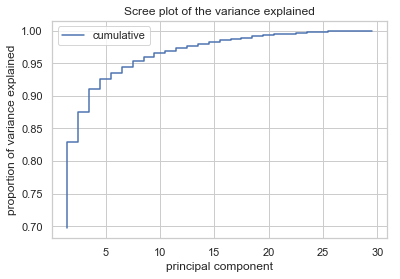

In [84]:
# code taken as such from the course

# Create bar plot
fig = plt.figure()
xcor = np.arange(1, len(pve) + 1) 

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, 
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.title('Scree plot of the variance explained')
plt.show()

We see that the first components play a big role in the analysis, but that we have diminishing returns for all new component.

Let's now see the number of components needed in order to reach the different threshold of 10%, 20%, ..., 100%

In [85]:
# code taken as such from the course
nb_components = []
threshold = []
for limit in np.arange(0.1,1.1,0.1):
    count = len([i for i in pve.cumsum() if i < limit])
    threshold.append(limit)
    nb_components.append(count)
pd.DataFrame({'Explained variance': threshold, 'Nb components needed': nb_components})

Explained variance  Nb components needed
0                 0.1                     0
1                 0.2                     0
2                 0.3                     0
3                 0.4                     0
4                 0.5                     0
5                 0.6                     0
6                 0.7                     1
7                 0.8                     1
8                 0.9                     3
9                 1.0                    29

We see that most of the variance can be explain with a very limited number of components.  

We now want to understand how the components are related to the underlying features. Let's have a visual interpretation of the two first components.

## PCA on df_eng <a class="anchor" id="PCA2"></a>

In [86]:
pca = PCA(n_components=2) # 2 components
X_2d = pca.fit_transform(X_eng)

In [87]:
# code taken as such from the course

scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_eng)

# Create DataFrame with variance and principal components
results_df = pd.DataFrame({
    'variance': X_rescaled.var(axis=0),
    '1st component': pca.components_[0],
    '2nd component': pca.components_[1]
}).set_index(X_eng.columns)

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For our visual interpretation, we want to have features that are highly correlated (positively or negatively) to one or both of the components.  

In [88]:
results_df.sort_values('1st component', ascending=False)

variance  1st component  2nd component
nb_P                          1.0       0.943434      -0.020978
nb_pawns_b_g_col              1.0       0.164675       0.008433
w_nb_pieces_1st_row           1.0       0.150468      -0.139107
b_nb_pieces_1st_row           1.0       0.122185      -0.231034
nb_pawns_third_row_c_f        1.0       0.106560      -0.081213
nb_captures                   1.0       0.096462       0.758744
nb_pawns_ext_center           1.0       0.086366      -0.004730
nb_pawns_center               1.0       0.055435      -0.110646
nb_p                          1.0       0.028334      -0.479846
nb_b                          1.0       0.020057      -0.067080
b_king_1st_row                1.0       0.015963      -0.045500
nb_moves                      1.0       0.015402       0.161172
nb_r                          1.0       0.011125      -0.047613
nb_n                          1.0       0.010350      -0.042796
nb_q                          1.0       0.009390      -0.030212
nb_k                          1.0       0.001277      -0.002522
king_castle_squares           1.0      -0.008796      -0.057477
nb_pieces_ext_center          1.0      -0.008899      -0.007822
nb_checks                     1.0      -0.011577      -0.052016
nb_pieces_center              1.0      -0.011610      -0.000842
w_king_1st_row                1.0      -0.016131      -0.061188
nb_pieces_b_g_col             1.0      -0.021916      -0.000694
nb_Q                          1.0      -0.023849      -0.050419
knight_squares                1.0      -0.028695      -0.100848
nb_pieces_third_row_c_f       1.0      -0.032176      -0.133461
nb_K                          1.0      -0.032593      -0.019295
nb_B                          1.0      -0.042969      -0.106222
nb_N                          1.0      -0.049810      -0.065888
nb_R                          1.0      -0.055248      -0.089752

In [89]:
results_df.sort_values('2nd component', ascending=False)

variance  1st component  2nd component
nb_captures                   1.0       0.096462       0.758744
nb_moves                      1.0       0.015402       0.161172
nb_pawns_b_g_col              1.0       0.164675       0.008433
nb_pieces_b_g_col             1.0      -0.021916      -0.000694
nb_pieces_center              1.0      -0.011610      -0.000842
nb_k                          1.0       0.001277      -0.002522
nb_pawns_ext_center           1.0       0.086366      -0.004730
nb_pieces_ext_center          1.0      -0.008899      -0.007822
nb_K                          1.0      -0.032593      -0.019295
nb_P                          1.0       0.943434      -0.020978
nb_q                          1.0       0.009390      -0.030212
nb_n                          1.0       0.010350      -0.042796
b_king_1st_row                1.0       0.015963      -0.045500
nb_r                          1.0       0.011125      -0.047613
nb_Q                          1.0      -0.023849      -0.050419
nb_checks                     1.0      -0.011577      -0.052016
king_castle_squares           1.0      -0.008796      -0.057477
w_king_1st_row                1.0      -0.016131      -0.061188
nb_N                          1.0      -0.049810      -0.065888
nb_b                          1.0       0.020057      -0.067080
nb_pawns_third_row_c_f        1.0       0.106560      -0.081213
nb_R                          1.0      -0.055248      -0.089752
knight_squares                1.0      -0.028695      -0.100848
nb_B                          1.0      -0.042969      -0.106222
nb_pawns_center               1.0       0.055435      -0.110646
nb_pieces_third_row_c_f       1.0      -0.032176      -0.133461
w_nb_pieces_1st_row           1.0       0.150468      -0.139107
b_nb_pieces_1st_row           1.0       0.122185      -0.231034
nb_p                          1.0       0.028334      -0.479846

Based on this, we see that only one feature (number of white pawns) explains the majority of the first component. The other features that are correlated to this first components are mainly the ones refer to the positioning of the pawns on certain squares (which is coherent as these features are clearly correlated to the number of pawns), or the number of pieces. No feature is clearly negatively correlated to it neither.  
Regarding the second component, it has more to do with the number of pieces on the board. The number of captures is highly correlated to it and all features related to the number of pieces are negatively correlated to it (which makes sense: the more captures, the less pieces on the board). 


Let's visualise these main features on a plot. 

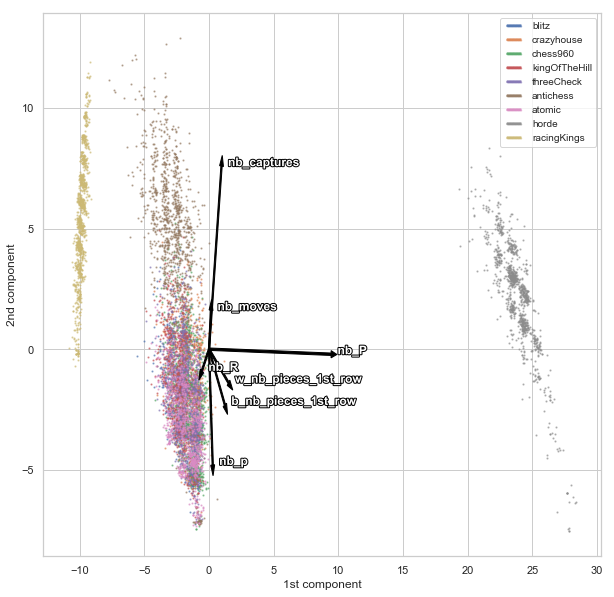

In [90]:
# code highly inspired by code in the course

fig=plt.figure(figsize=(10, 10))
# Plot each kind of wine
for kind in variants:
    # Wine samples of this type
    idx = (y_eng == kind)

    # Plot their components
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label=kind,
        s=1.5,
        alpha=0.5
    )

# Plot a few features using the weights in the loading vectors
for feature in ['nb_P', 'nb_R', 'w_nb_pieces_1st_row', 'nb_p',
                'b_nb_pieces_1st_row', 'nb_captures', 'nb_moves']:
    # Get weights
    weight1 = results_df.loc[feature, '1st component']*10
    weight2 = results_df.loc[feature, '2nd component']*10 

    # Plot arrows
    plt.arrow(
        0, 0, 
        weight1, weight2,
        color='black', width=0.1)

    # Add text
    text = plt.text(
        weight1 + 0.5 , 
        weight2 ,
        feature, 
        weight='bold', color='white')

    # Make the text stand out
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()])

# Labels and legend
lgnd = plt.legend(loc="upper right", scatterpoints=30, fontsize=10)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

The graph confirms what has been said regarding the different features and their correlations to the components.  
We also see that we clearly have 3 groups that have been formed.  
Horde and racingKings should be extermely easy to predict as horde presents a extremely high number of pawns and racinKings no white pawns.
In addition to that, antichess seems also a little bit appart from the rest of the group with a high number of captures, leaving us with 6 variants that will be more difficult to predict.  
We want to have a deeper look at these variants by removing the other ones. This will definitely help as the two variants mostly correlated with the first components will be removed.  

### PCA with challenging variants

We start by isolating only the variants of interest for both dataframes ("eng" and "full" that will be used later). 

In [91]:
var_of_interest = ['blitz', 'crazyhouse', 'chess960', 'kingOfTheHill', 'threeCheck', 'atomic'] # variants of interest

In [97]:
# working only on the variants of interest for both dataframes: "engineered" and "augmented"
df_feat_eng_selection = df_feat_eng[df_feat_eng["variant"].isin(var_of_interest)]
df_full_selection = full_df[full_df["variant"].isin(var_of_interest)] 

In [98]:
X_eng_selection = df_feat_eng_selection.drop('variant', axis=1)
y_eng_selection = df_feat_eng_selection['variant']
X_full_selection = df_full_selection.drop('variant', axis=1)
y_full_selection = df_full_selection['variant']

In [101]:
print(X_eng_selection.shape,
X_full_selection.shape)

(6000, 29) (6000, 477)


In [102]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_eng_selection)

In [103]:
# code taken as such from the course

scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_eng)

# Create DataFrame with variance and principal components
results_df = pd.DataFrame({
    'variance': X_rescaled.var(axis=0),
    '1st component': pca.components_[0],
    '2nd component': pca.components_[1]
}).set_index(X_eng.columns)

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For our visual interpretation, we want to have features that are highly correlated (positively or negatively) to one or both of the components.  

In [104]:
results_df.sort_values('1st component', ascending=False)

variance  1st component  2nd component
w_nb_pieces_1st_row           1.0       0.221323       0.140950
b_nb_pieces_1st_row           1.0       0.204323       0.109345
nb_P                          1.0       0.114829      -0.150956
nb_p                          1.0       0.082878      -0.178629
nb_n                          1.0       0.035186      -0.072180
nb_B                          1.0       0.034337      -0.056984
nb_N                          1.0       0.030391      -0.069543
nb_b                          1.0       0.009518      -0.049522
nb_R                          1.0       0.008139      -0.009854
nb_r                          1.0       0.005887      -0.009943
nb_Q                          1.0       0.001052      -0.055183
nb_pawns_b_g_col              1.0       0.000199      -0.128774
nb_q                          1.0      -0.001734      -0.048807
nb_pawns_ext_center           1.0      -0.002669      -0.067290
nb_pawns_third_row_c_f        1.0      -0.005138      -0.182261
nb_pawns_center               1.0      -0.008828      -0.155830
w_king_1st_row                1.0      -0.015323      -0.028117
nb_pieces_center              1.0      -0.016114       0.035422
nb_K                          1.0      -0.019807      -0.009958
nb_pieces_b_g_col             1.0      -0.028278      -0.055185
nb_pieces_ext_center          1.0      -0.028410      -0.008387
b_king_1st_row                1.0      -0.031012      -0.038626
nb_checks                     1.0      -0.032841       0.233455
nb_k                          1.0      -0.033240      -0.014517
king_castle_squares           1.0      -0.064604      -0.144658
knight_squares                1.0      -0.151054      -0.351684
nb_pieces_third_row_c_f       1.0      -0.209348      -0.360360
nb_captures                   1.0      -0.567577       0.625720
nb_moves                      1.0      -0.697830      -0.293330

In [105]:
results_df.sort_values('2nd component', ascending=False)

variance  1st component  2nd component
nb_captures                   1.0      -0.567577       0.625720
nb_checks                     1.0      -0.032841       0.233455
w_nb_pieces_1st_row           1.0       0.221323       0.140950
b_nb_pieces_1st_row           1.0       0.204323       0.109345
nb_pieces_center              1.0      -0.016114       0.035422
nb_pieces_ext_center          1.0      -0.028410      -0.008387
nb_R                          1.0       0.008139      -0.009854
nb_r                          1.0       0.005887      -0.009943
nb_K                          1.0      -0.019807      -0.009958
nb_k                          1.0      -0.033240      -0.014517
w_king_1st_row                1.0      -0.015323      -0.028117
b_king_1st_row                1.0      -0.031012      -0.038626
nb_q                          1.0      -0.001734      -0.048807
nb_b                          1.0       0.009518      -0.049522
nb_Q                          1.0       0.001052      -0.055183
nb_pieces_b_g_col             1.0      -0.028278      -0.055185
nb_B                          1.0       0.034337      -0.056984
nb_pawns_ext_center           1.0      -0.002669      -0.067290
nb_N                          1.0       0.030391      -0.069543
nb_n                          1.0       0.035186      -0.072180
nb_pawns_b_g_col              1.0       0.000199      -0.128774
king_castle_squares           1.0      -0.064604      -0.144658
nb_P                          1.0       0.114829      -0.150956
nb_pawns_center               1.0      -0.008828      -0.155830
nb_p                          1.0       0.082878      -0.178629
nb_pawns_third_row_c_f        1.0      -0.005138      -0.182261
nb_moves                      1.0      -0.697830      -0.293330
knight_squares                1.0      -0.151054      -0.351684
nb_pieces_third_row_c_f       1.0      -0.209348      -0.360360

We see that the components are much more "diversified" in terms of features, and that the number of pawns is not sufficient enough to capture most of the variance.

Let's visualise the main features on a plot. 

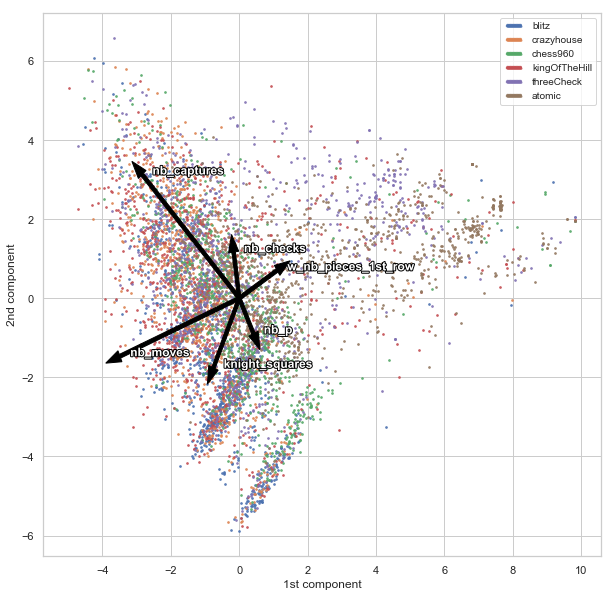

In [106]:
# code highly inspired by code in the course

fig=plt.figure(figsize=(10, 10))
# Plot each kind of wine
for kind in var_of_interest:
    # Wine samples of this type
    idx = (y_eng_selection == kind)

    # Plot their components
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label=kind,
        s=3,
        alpha=0.8
    )

# Plot a few features using the weights in the loading vectors
for feature in ['nb_moves', 'nb_captures', 'knight_squares', 'w_nb_pieces_1st_row', 
                # 'b_nb_pieces_1st_row', # almost the same as w_nb_pieces_1st_row
                'nb_checks', 'nb_p']:
    # Get weights
    weight1 = results_df.loc[feature, '1st component']*5
    weight2 = results_df.loc[feature, '2nd component']*5 

    # Plot arrows
    plt.arrow(
        0, 0, 
        weight1, weight2,
        color='black', width=0.1)

    # Add text
    text = plt.text(
        weight1 +0.3, 
        weight2,
        feature, 
        weight='bold', color='white')

    # Make the text stand out
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()])

# Labels and legend
lgnd = plt.legend(loc="upper right", scatterpoints=30, fontsize=10)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

While the previous graph was quite deceving as only "one big block" could be distinguished for these five variants, we see here that there are still some sources of differences (for instance blitz seems more negatively correlated to the 2nd component, atomic presents more pieces on the first rows). 

## PCA on all the features <a class="anchor" id="PCA2"></a>

In [107]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_full)

In [108]:
# code taken as such from the course
pca = PCA(n_components=None)
pca.fit(X_full)
pve = pca.explained_variance_ratio_
np.round(pve,3)[0:10]

array([0.595, 0.115, 0.045, 0.035, 0.014, 0.01 , 0.009, 0.008, 0.007,
       0.006])

We see that the first component explains here a bit less than previously but still almost 60%. This is quite good given the large number of features that we have.  

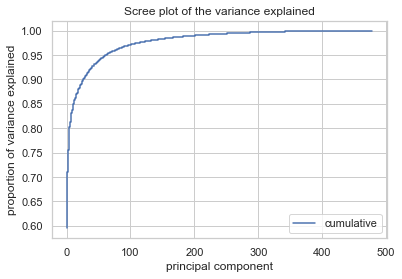

In [109]:
# code taken as such from the course

# Create bar plot
fig = plt.figure()
xcor = np.arange(1, len(pve) + 1) 

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, 
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.title('Scree plot of the variance explained')
plt.show()

We however see that the diminishing returns are important when the number of components incrases significantly.  

In [110]:
nb_components = []
threshold = []
for limit in np.arange(0.1,1.1,0.1):
    count = len([i for i in pve.cumsum() if i < limit])
    threshold.append(limit)
    nb_components.append(count)
pd.DataFrame({'Explained variance': threshold, 'Nb components needed': nb_components})

Explained variance  Nb components needed
0                 0.1                     0
1                 0.2                     0
2                 0.3                     0
3                 0.4                     0
4                 0.5                     0
5                 0.6                     1
6                 0.7                     1
7                 0.8                     4
8                 0.9                    26
9                 1.0                   449

We now need less components to explain the same amount of variance.  
Let's build a plot to have a representation of the two main components and the most correlated features to these components. 

In [111]:
pca = PCA(n_components=2) # 2 components
X_2d = pca.fit_transform(X_full)

In [113]:
# code taken as such from the course

scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_full)

# Create DataFrame with variance and principal components
results_df = pd.DataFrame({
    'variance': X_rescaled.var(axis=0),
    '1st component': pca.components_[0],
    '2nd component': pca.components_[1]
}).set_index(X_full.columns)

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For our visual interpretation, we want to have features that are highly correlated (positively or negatively) to one or both of the components.  
Let's find these features.

In [114]:
results_df.sort_values('1st component', ascending=False).head(10)

variance  1st component  2nd component
nb_P                         1.0       0.923961      -0.009975
nb_pawns_b_g_col             1.0       0.161299       0.017578
w_nb_pieces_1st_row          1.0       0.147507      -0.139047
b_nb_pieces_1st_row          1.0       0.120067      -0.235779
nb_pawns_third_row_c_f       1.0       0.104396      -0.077970
nb_captures                  1.0       0.093465       0.708929
nb_pawns_ext_center          1.0       0.084628      -0.000095
nb_pawns_center              1.0       0.054427      -0.108311
g1_p                         1.0       0.032997       0.017448
b1_p                         1.0       0.032963       0.017431

In [115]:
results_df.sort_values('1st component', ascending=True).head(10)

variance  1st component  2nd component
nb_R                          1.0      -0.053999      -0.090689
nb_N                          1.0      -0.048655      -0.064832
nb_B                          1.0      -0.041914      -0.104297
nb_K                          1.0      -0.031897      -0.019578
nb_pieces_third_row_c_f       1.0      -0.031279      -0.134094
knight_squares                1.0      -0.027941      -0.099174
nb_Q                          1.0      -0.023264      -0.048600
nb_pieces_b_g_col             1.0      -0.021423       0.002524
a1_r                          1.0      -0.016407      -0.058707
w_king_1st_row                1.0      -0.015733      -0.063227

In [116]:
results_df.sort_values('2nd component', ascending=False).head(10)

variance  1st component  2nd component
nb_captures            1.0       0.093465       0.708929
nb_moves               1.0       0.014911       0.151057
nb_pawns_b_g_col       1.0       0.161299       0.017578
g1_p                   1.0       0.032997       0.017448
c1_p                   1.0       0.032914       0.017443
f1_p                   1.0       0.032956       0.017439
b1_p                   1.0       0.032963       0.017431
d1_p                   1.0       0.031655       0.017337
e1_p                   1.0       0.031390       0.017295
a1_p                   1.0       0.032272       0.017292

In [117]:
results_df.sort_values('2nd component', ascending=True).head(10)

variance  1st component  2nd component
nb_p                          1.0       0.028371      -0.488806
b_nb_pieces_1st_row           1.0       0.120067      -0.235779
w_nb_pieces_1st_row           1.0       0.147507      -0.139047
nb_pieces_third_row_c_f       1.0      -0.031279      -0.134094
nb_pawns_center               1.0       0.054427      -0.108311
nb_B                          1.0      -0.041914      -0.104297
knight_squares                1.0      -0.027941      -0.099174
nb_R                          1.0      -0.053999      -0.090689
nb_pawns_third_row_c_f        1.0       0.104396      -0.077970
nb_b                          1.0       0.019758      -0.065073

Let's visualise these main features on a plot. 

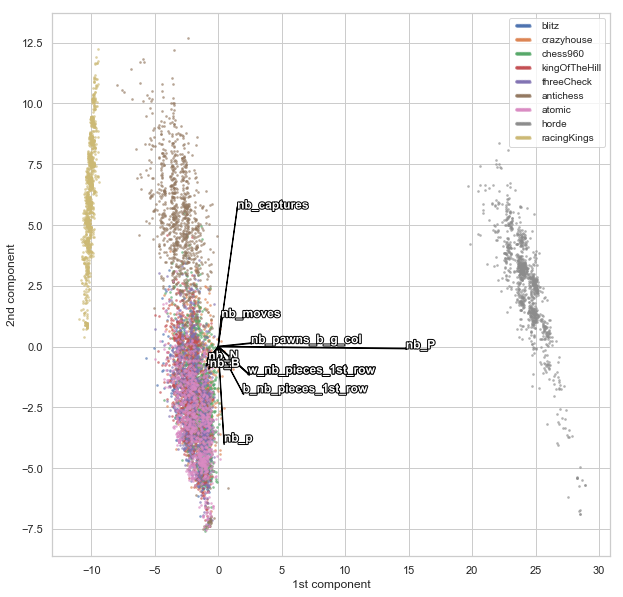

In [125]:
# code highly inspired by code in the course

fig=plt.figure(figsize=(10, 10))
# Plot each kind of wine
for kind in variants:
    # Wine samples of this type
    idx = (y_eng == kind)

    # Plot their components
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label=kind,
        s=3,
        alpha=.5
    )

# Plot a few features using the weights in the loading vectors
for feature in ['nb_P', 'nb_pawns_b_g_col', 'w_nb_pieces_1st_row', 'nb_R', 'nb_N', 'nb_B', 
                'nb_captures', 'nb_moves', 'nb_p', 'b_nb_pieces_1st_row', 'w_nb_pieces_1st_row']:
    # Get weights
    weight1 = results_df.loc[feature, '1st component']*16
    weight2 = results_df.loc[feature, '2nd component']*8

    # Plot arrows
    plt.arrow(
        0, 0, 
        weight1, weight2,
        color='black', width=0.03)

    # Add text
    text = plt.text(
        weight1  , 
        weight2 ,
        feature, 
        weight='bold', color='white')

    # Make the text stand out
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()])

# Labels and legend
lgnd = plt.legend(loc="upper right", scatterpoints=30, fontsize=10)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

The same conclusions can be taken as previously as for the first PCA on df_eng, meaning that the engineered features do a good job a capturing most of the variance.

Let's do the analysis on the challenging variants only. 

In [126]:
pca = PCA(n_components=2) # 2 components
X_2d = pca.fit_transform(X_full_selection)

In [127]:
# code taken as such from the course

scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_full_selection)

# Create DataFrame with variance and principal components
results_df = pd.DataFrame({
    'variance': X_rescaled.var(axis=0),
    '1st component': pca.components_[0],
    '2nd component': pca.components_[1]
}).set_index(X_full_selection.columns)

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For our visual interpretation, we want to have features that are highly correlated (positively or negatively) to one or both of the components.  

In [128]:
results_df.sort_values('1st component', ascending=False).head(10)

variance  1st component  2nd component
w_nb_pieces_1st_row       1.0       0.243316       0.020642
b_nb_pieces_1st_row       1.0       0.211946      -0.000420
b1_n                      1.0       0.087602       0.036450
b1_white                  1.0       0.083436       0.030461
b8_n                      1.0       0.076508       0.021007
d2_p                      1.0       0.070556       0.010044
g8_n                      1.0       0.067032       0.029443
c1_b                      1.0       0.065834       0.030337
h1_r                      1.0       0.065521       0.048226
h1_white                  1.0       0.063337       0.046533

In [129]:
results_df.sort_values('1st component', ascending=True).head(10)

variance  1st component  2nd component
nb_moves                      1.0      -0.697367       0.057585
nb_pieces_third_row_c_f       1.0      -0.308892      -0.217996
nb_captures                   1.0      -0.284129       0.772365
knight_squares                1.0      -0.258040      -0.240072
king_castle_squares           1.0      -0.119331      -0.111094
c3_white                      1.0      -0.071480      -0.055959
f3_white                      1.0      -0.067499      -0.060703
nb_pawns_third_row_c_f        1.0      -0.063129      -0.150065
nb_pawns_center               1.0      -0.062086      -0.130831
f3_n                          1.0      -0.061158      -0.056051

In [130]:
results_df.sort_values('2nd component', ascending=False).head(10)

variance  1st component  2nd component
nb_captures            1.0      -0.284129       0.772365
nb_checks              1.0       0.062895       0.223140
nb_moves               1.0      -0.697367       0.057585
h8_r                   1.0       0.057126       0.049422
h1_r                   1.0       0.065521       0.048226
h1_white               1.0       0.063337       0.046533
nb_pieces_center       1.0      -0.001784       0.037776
b1_n                   1.0       0.087602       0.036450
e1_k                   1.0       0.045506       0.032542
f8_b                   1.0       0.062638       0.032321

In [131]:
results_df.sort_values('2nd component', ascending=True).head(10)

variance  1st component  2nd component
knight_squares                1.0      -0.258040      -0.240072
nb_pieces_third_row_c_f       1.0      -0.308892      -0.217996
nb_p                          1.0       0.009847      -0.189701
nb_P                          1.0       0.051329      -0.177302
nb_pawns_third_row_c_f        1.0      -0.063129      -0.150065
nb_pawns_center               1.0      -0.062086      -0.130831
nb_pawns_b_g_col              1.0      -0.043773      -0.112901
king_castle_squares           1.0      -0.119331      -0.111094
nb_n                          1.0       0.006640      -0.076100
nb_N                          1.0       0.002332      -0.073000

Let's visualise these main features on a plot. 

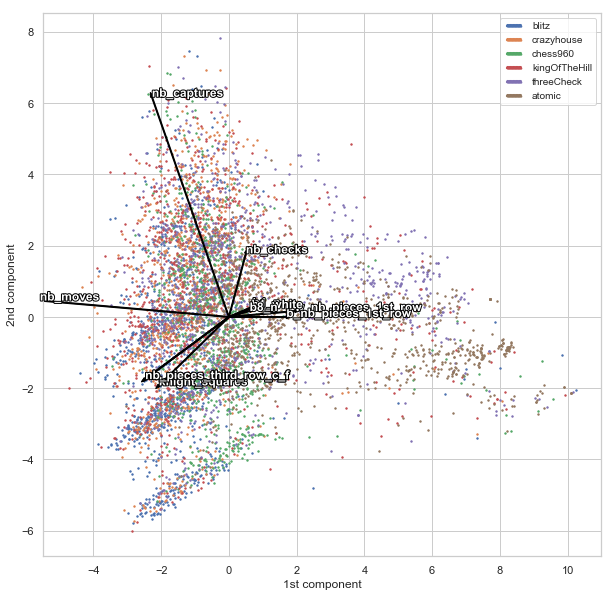

In [132]:
# code highly inspired by code in the course

fig=plt.figure(figsize=(10, 10))
# Plot each kind of wine
for kind in var_of_interest:
    # Wine samples of this type
    idx = (y_eng_selection == kind)

    # Plot their components
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 1],
        label=kind,
        s=2
    )

# Plot a few features using the weights in the loading vectors
for feature in ['w_nb_pieces_1st_row', 'b_nb_pieces_1st_row', 'b1_n', 'b1_white', 'b8_n', 'nb_moves', 
                'nb_pieces_third_row_c_f', 'nb_captures', 'nb_checks', 'knight_squares', 'nb_pieces_third_row_c_f']:
    # Get weights
    weight1 = results_df.loc[feature, '1st component']*8
    weight2 = results_df.loc[feature, '2nd component']*8

    # Plot arrows
    plt.arrow(
        0, 0, 
        weight1, weight2,
        color='black', width=0.03)

    # Add text
    text = plt.text(
        weight1  , 
        weight2 ,
        feature, 
        weight='bold', color='white')

    # Make the text stand out
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()])

# Labels and legend
lgnd = plt.legend(loc="upper right", scatterpoints=30, fontsize=10)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

Again, we see that we have some sources of variance even within this "big" cluster. We can try to add a third component to the visualisation:

In [133]:
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_full_selection)

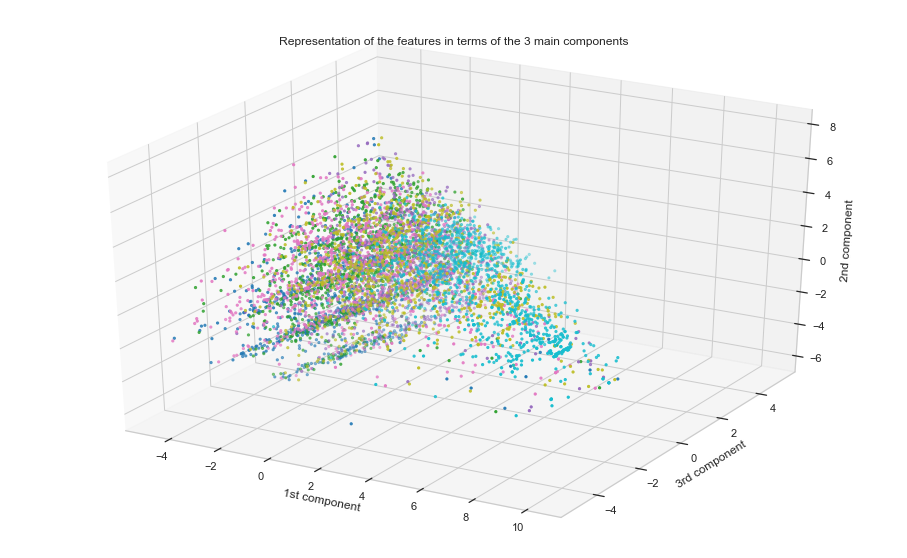

In [134]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=[row[0] for row in X_3d],
    ys=[row[2] for row in X_3d],
    zs=[row[1] for row in X_3d],
    c=pd.factorize(y_aug_selection)[0] + 1,
    cmap='tab10',
    s=5
)

ax.set_xlabel('1st component')
ax.set_ylabel('3rd component')
ax.set_zlabel('2nd component')
plt.title('Representation of the features in terms of the 3 main components')
plt.show()

We started by a PCA with two components on the engineered features only. We could not easily see any patterns on 6 challenging variants. Here, we end up with a more heterogeneous block here where we can distringuish some groups.  
Again, this is using only 3 components and including more components should provide even better outcomes. 
That's a good reason to test models using PCA in the modelling part.

# EDA output

Through this EDA, more insights on the data could be gained. 

After scrapping the data from lichess, and cleaning it to ensure completeness in these preprocessing steps and no data was missing, it was quickly possible to guess some patterns by plotting randomly positions from the different variants.  
In an iterative process, different features extracted from the positions were created, analyzed and eventually included in a "feature engineered" data frame.  
Quickly, it was possible to distinguish variants that would be easy to predict as multiple features discriminated them well. On the other side, other variants where much more challenging to predict, even if some features have proven to vary between the remaining variants.  
The PCA confirmed the first insights but gave enthusiatic signals regarding the continuation of the project.  

Let us now move to the modelling part. 